# Exploratory Data Analysis Part 3

### This notebook is the third part of the intial exploratory data analysis. Continuous variables were examined in Part 2; now categorical variables will be examined in Part 3, prior to beginning model construction.

Start by importing the data and relevant libraries:

In [1]:
# Load libraries required for data analysis
library(tidyverse)
library(scales) # for improving graph scale display quality
library(gridExtra) # displaying plots in rows / columns
library(boot) # calculating correlation coefficient between two variables

# Load data (already downloaded and saved locally)
train <- read_csv("train.csv",show_col_types = FALSE)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




Part 1 of the EDA concluded with dropping the NA values in the columns: LotFrontage, Electrical, MasVnrType, MasVnrArea. Let's start by doing that:

In [2]:
train <- train %>% drop_na(LotFrontage, Electrical, MasVnrType, MasVnrArea)

There were a few features where NA was meaningful, as indicated in the documentation. These are:

In [3]:
NA_columns <- names(train)[sapply(train,anyNA)]
NA_columns

[1] "Alley"        "BsmtQual"     "BsmtCond"     "BsmtExposure" "BsmtFinType1"
 [6] "BsmtFinType2" "FireplaceQu"  "GarageType"   "GarageYrBlt"  "GarageFinish"
[11] "GarageQual"   "GarageCond"   "PoolQC"       "Fence"        "MiscFeature"

In Part 2 of the EDA there were outliers that were noted in the variables LotFrontage, LotArea, and GrLivArea (Above Ground Living Area). Let's also remove these outliers from the data:

In [4]:
train <- train %>%
    filter(LotFrontage < 300) %>%
    filter(LotArea < 200000) %>%
    filter(GrLivArea < 4500)

Alright, the data is ready and time to pick up where Part 2 left off. First, let's take the axis label function from Part 2 and expand it to include the categorical variables:

In [5]:
# Define a switch function to convert the column names in the data file into more human parsable labels
axis_label <- function(column) {
    axis_label <- switch(column,
                      'SalePrice' = 'Sale Price ($)',
                      'LotFrontage' = 'Lot Frontage (ft.)',
                      'LotArea' = 'Lot Area (sq. ft.)',
                      'YearBuilt' = 'Year Built',
                      'YearRemodAdd' = 'Year Remodeled',
                      'GrLivArea' = 'Above Grade Living Area (sq. ft.)',
                      'TotalBsmtSF' = 'Total Basement Area (sq. ft.)',
                      'BsmtFinSF1' = 'Type 1 Finished Basement Area (sq. ft.)',
                      'BsmtFinSF2' = 'Type 2 Finished Basement Area (sq. ft.)',
                      'BsmtUnfSF' = 'Unfinished Basement Area (sq. ft.)',
                      '1stFlrSF' = 'First Floor Area (sq. ft.)',
                      '2ndFlrSF' = 'Second Floor Area (sq. ft.)',
                      'LowQualFinSF' = 'Low Quality Finished Area (sq. ft.)',
                      'TotRmsAbvGrd' = 'Total Rooms Above Grade',
                      'GarageYrBlt' = 'Year Garage Built',
                      'GarageArea' = 'Garage Area (sq. ft.)',
                      'WoodDeckSF' = 'Wood Deck Area (sq. ft.)',
                      'OpenPorchSF' = 'Open Porch Area (sq. ft.)',
                      'EnclosedPorch' = 'Enclosed Porch Area (sq. ft.)',
                      '3SsnPorch' = 'Three Season Porch Area (sq. ft.)',
                      'ScreenPorch' = 'Screened Porch Area (sq. ft.)',
                      'PoolArea' = 'Pool Area (sq.ft.)',
                      'MSSubClass' = 'Dwelling Type Code',
                      'MSZoning' = 'Zoning Classification',
                      'Street' = 'Street',
                      'Alley' = 'Alley',
                      'LotShape' = 'Lot Shape',
                      'LandContour' = 'Land Contours',
                      'Utilities' = 'Types of Utilities Available',
                      'LotConfig' = 'Lot Configuration',
                      'LandSlope' = 'Slope of Property',
                      'Neighborhood' = 'Neighborhood where House Located',
                      'Condition1' = 'Proximity to various Conditions',
                      'Condition2' = 'Proximity to various Additional Conditions',
                      'BldtType' = 'Building Type',
                      'HouseStyle' = 'House Style',
                      'OverallQual' = 'Rating for Overall Material & Finish of House',
                      'OverallCond' = 'Rating for Overall Condition of House',
                      'RoofStyle' = 'Roof Type',
                      'RoofMatl' = 'Roofing Material',
                      'Exterior1st' = 'House Siding Material',
                      'Exterior2nd' = 'House Siding Additional Material',
                      'MasVnrType' = 'Masonry Vaneer Type',
                      'MasVnrArea' = 'Masonry Vaneer Area (sq. ft.)',
                      'Foundation' = 'Type of Foundation',
                      'BsmtQual' = 'Height of Basement',
                      'Heating' = 'Heating Type',
                      'CentralAir' = 'Central Air Conditioning',
                      'Electrical' = 'Electrical System',
                      'BedroomAbvGr' = 'Bedrooms above grade',
                      'BsmtFullBath' = 'Basement full bathrooms',
                      'BsmtHalfBath' = 'Basement half bathrooms',
                      'FullBath' = 'Full bathrooms above grade',
                      'HalfBath' = 'Half bathrooms above grade',
                      'Fireplaces' = 'Number of fireplaces',
                      'GarageType' = 'Garage Location',
                      'PavedDrive' = 'Driveway Paving',
                      'MoSold' = 'Month Sold',
                      'YrSold' = 'Year Sold',
                      'SaleType' = 'Type of Sale',
                      'SaleCondition' = 'Condition of Sale')
    return(axis_label)
}

Now make a couple functions for plotting box plots for visualization:

In [6]:
# Define a function to make box plots of the data
plot_box <- function(data, x_column, y_column = 'SalePrice', width = 10, height = 8) {
    options(repr.plot.width = width, repr.plot.height = height)
    # count the number of houses present in each factor level
    data_count <- data %>% group_by(!!sym(x_column)) %>% summarize(data_count = n())
    zero_fct_vct <- rep(0, count(data_count))
    # add a column to position the house counts at y = 0
    data_count <- data_count %>%
      mutate(text_y_pos = zero_fct_vct)
    many_factors <- c('Neighborhood', 'Exterior1st', 'Exterior2nd')
    if (x_column %in% many_factors) {
        box_plot <- ggplot(data, aes(x = factor(!!sym(x_column)), y = !!sym(y_column))) +
          geom_boxplot() +
          geom_text(data = data_count, aes(x = factor(!!sym(x_column)), y = text_y_pos, label = paste('Count:\n', data_count))) + # display factor counts on the plots
          labs(x = axis_label(x_column), y = axis_label(y_column)) +
          theme(axis.title = element_text(size = 22),
                axis.text = element_text(size = 18),
                axis.text.x = element_text(angle = 90, vjust = 0.5)) #the features in this if statement have many factor levels, this is needed to make the x-axis readable)
        } else {
        box_plot <- ggplot(data, aes(x = factor(!!sym(x_column)), y = !!sym(y_column))) +
          geom_boxplot() +
          geom_text(data = data_count, aes(x = factor(!!sym(x_column)), y = text_y_pos, label = paste('Count:\n', data_count))) + # display factor counts on the plots
          labs(x = axis_label(x_column), y = axis_label(y_column)) +
          theme(axis.title = element_text(size = 22),
                axis.text = element_text(size = 18))
        }
    lrg_val <- c('SalePrice')
    # one axis should be a categorical variable, but leave both if ... else statements in place to allow flexibility on which orientation is used in the graph
    if (x_column %in% lrg_val) {
        box_plot_x <- box_plot + scale_x_continuous(label = label_comma())
    } else {
        box_plot_x <- box_plot
    }
    if (y_column %in% lrg_val) {
        box_plot_y <- box_plot_x + scale_y_continuous(label = label_comma())
    } else {
        box_plot_y <- box_plot_x
    }
    return(box_plot_y)
}
# Define a function to plot a group of box plots and arrange them in two columns
box_plots <- function(box_data, box_columns, plot_width = 20, plot_height = 18) {
  lapp_columns <- box_columns
  my_plots <- lapply(lapp_columns, plot_box, data = box_data, width = plot_width, height = plot_height)
  grid.arrange(grobs = my_plots, ncol = 2)
}

Now let's start by looking at dwelling type and zoning location to see if these influence sale price. Note that there is also a count of the number of houses in each categorical factor level included on these plots, because some of these features were observed in Part 1 of the EDA to have very skewed factor counts.

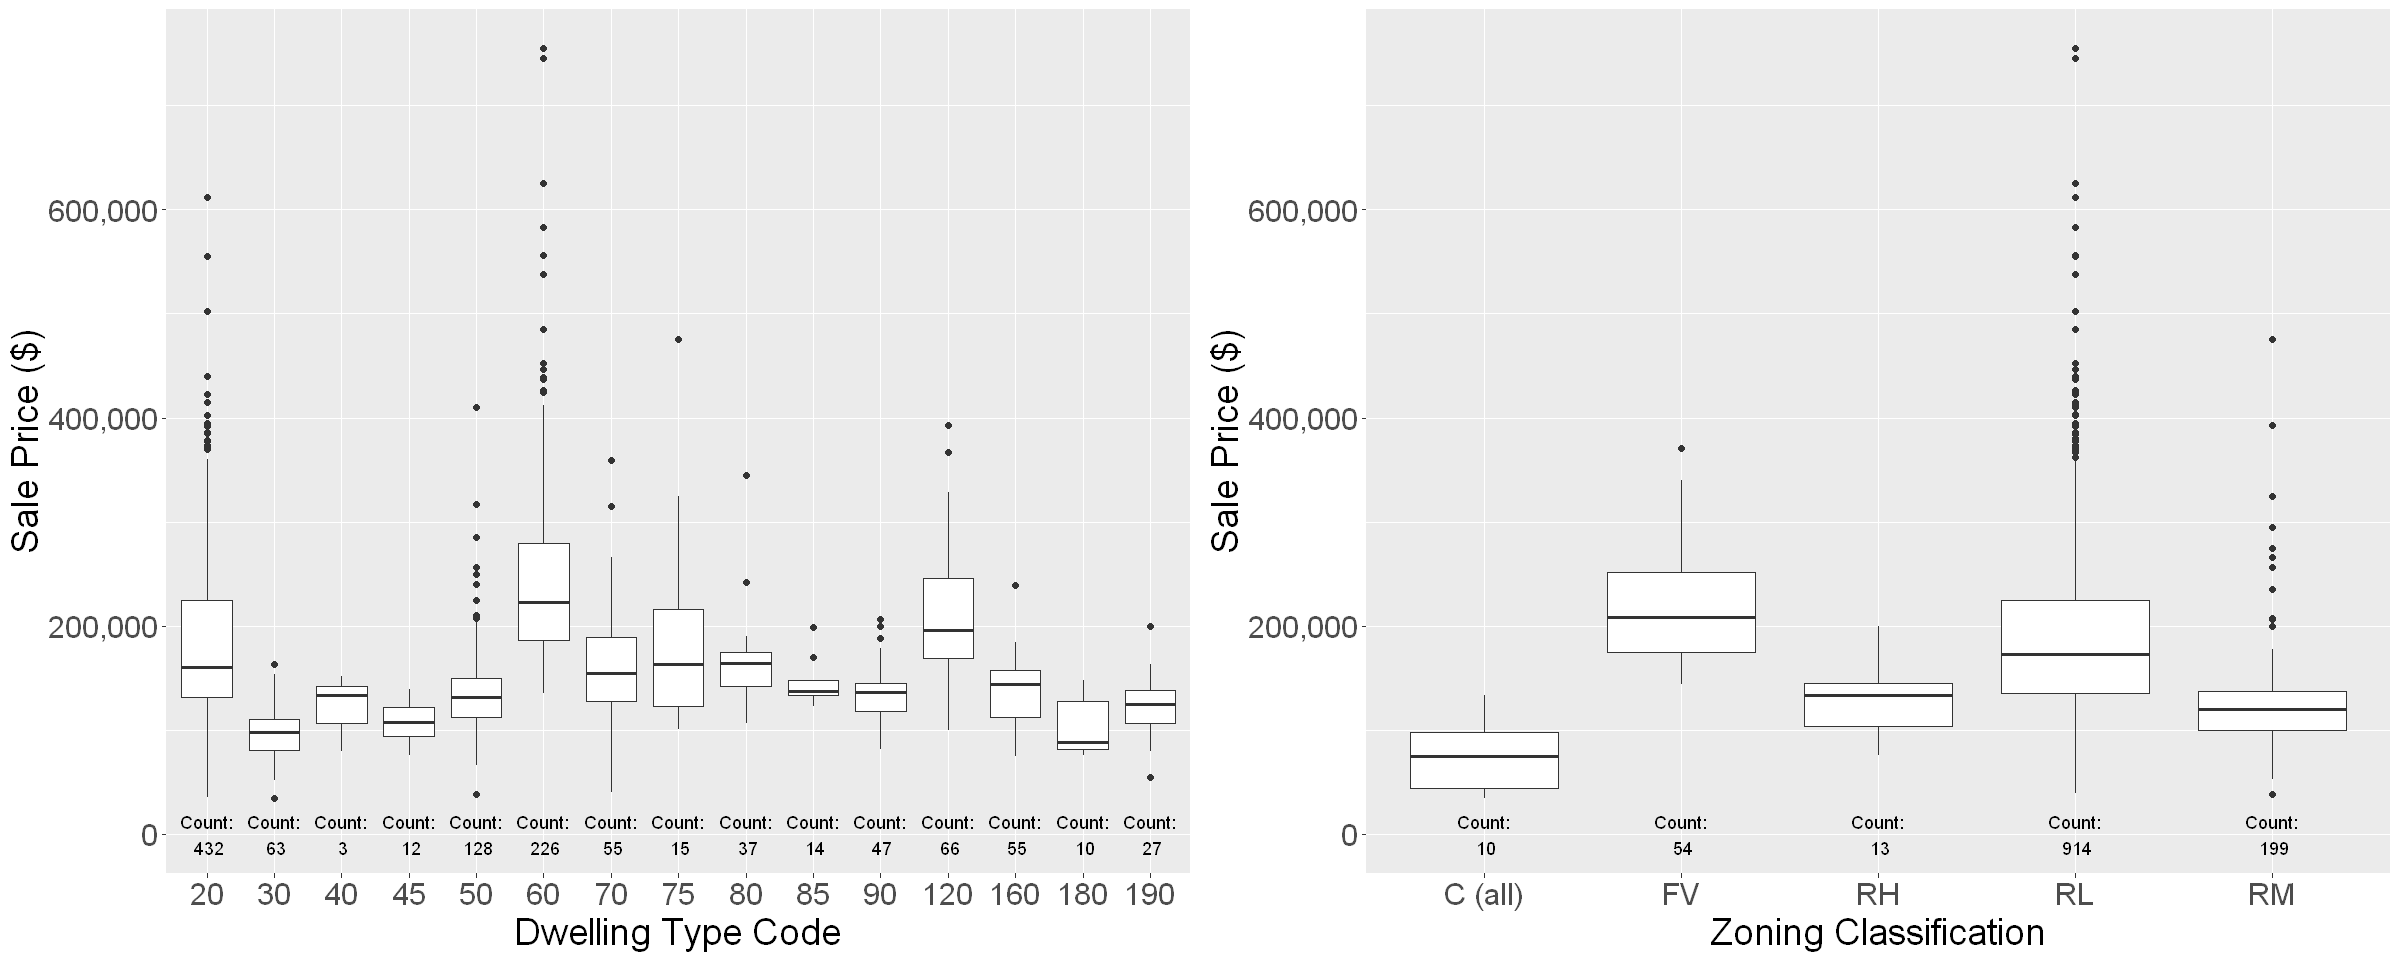

In [7]:
box_plots(train, c('MSSubClass', 'MSZoning'), plot_height = 8)

The different dwelling type (codes) appear to have an influence on the sale price, with the codes 20 (single story, 1946 & newer), 60 (two story, 1946 & newer), and 120 (single story, planned urban development, 1946 & newer) having the greatest median sale prices, with the first two of those categories also being the most common as well.

Zoning also appears to impact sales price. Floating Village (FV) (house boats and floating homes?) and Low Density Residential (RL) have the greatest house sale price, while higher density housing tends to have lower sale prices, as expected from intuition.

Note that the skew in the house sale price data is also obvious here with the high sale price outliers present in the box plots.

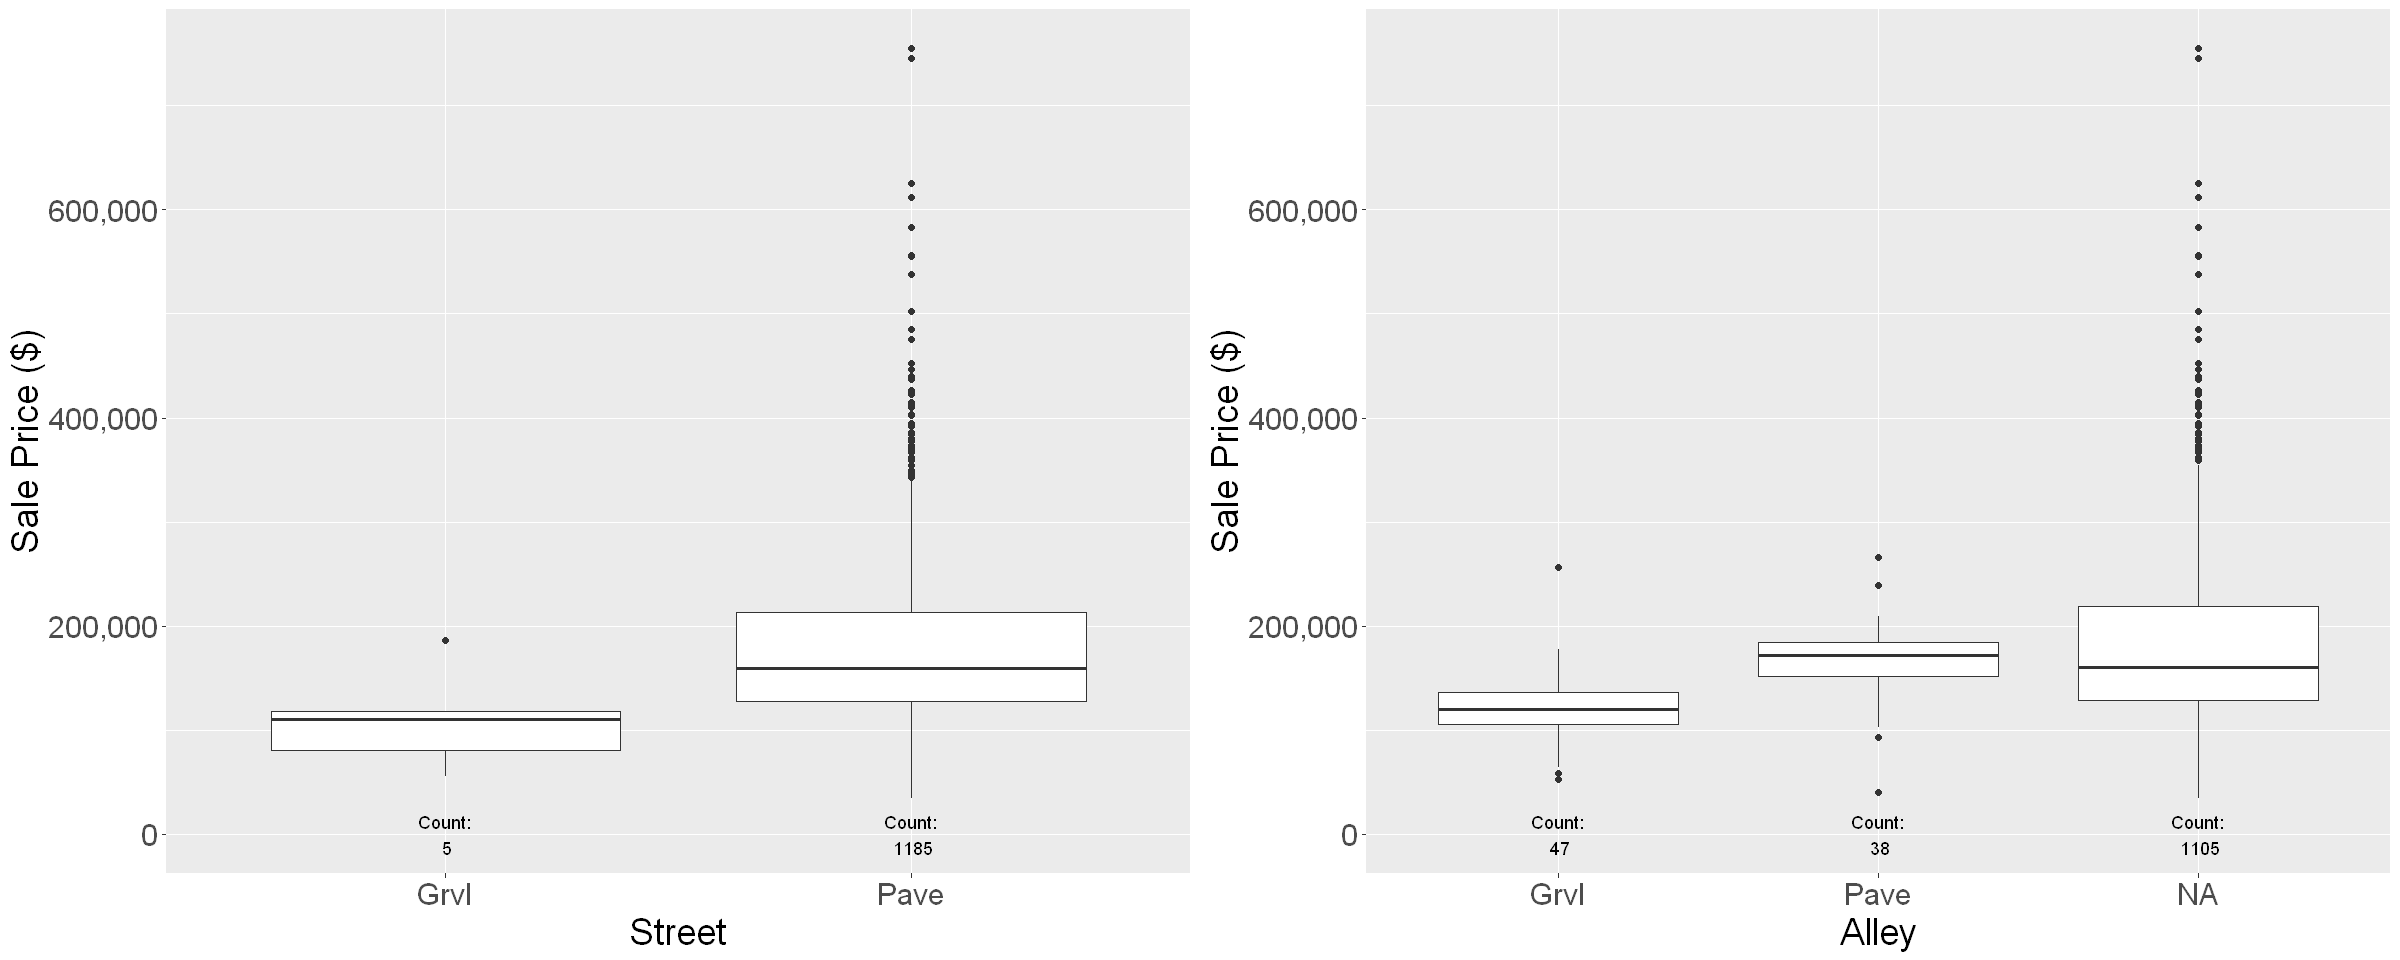

In [8]:
box_plots(train, c('Street', 'Alley'), plot_height = 8)

Almost all of the homes sold in this data set had access to a paved street, so the street variable is probably worth dropping. Most homes don't have alley access, but it does appear among those that do that whether the alley is paved or not does impace sale price.

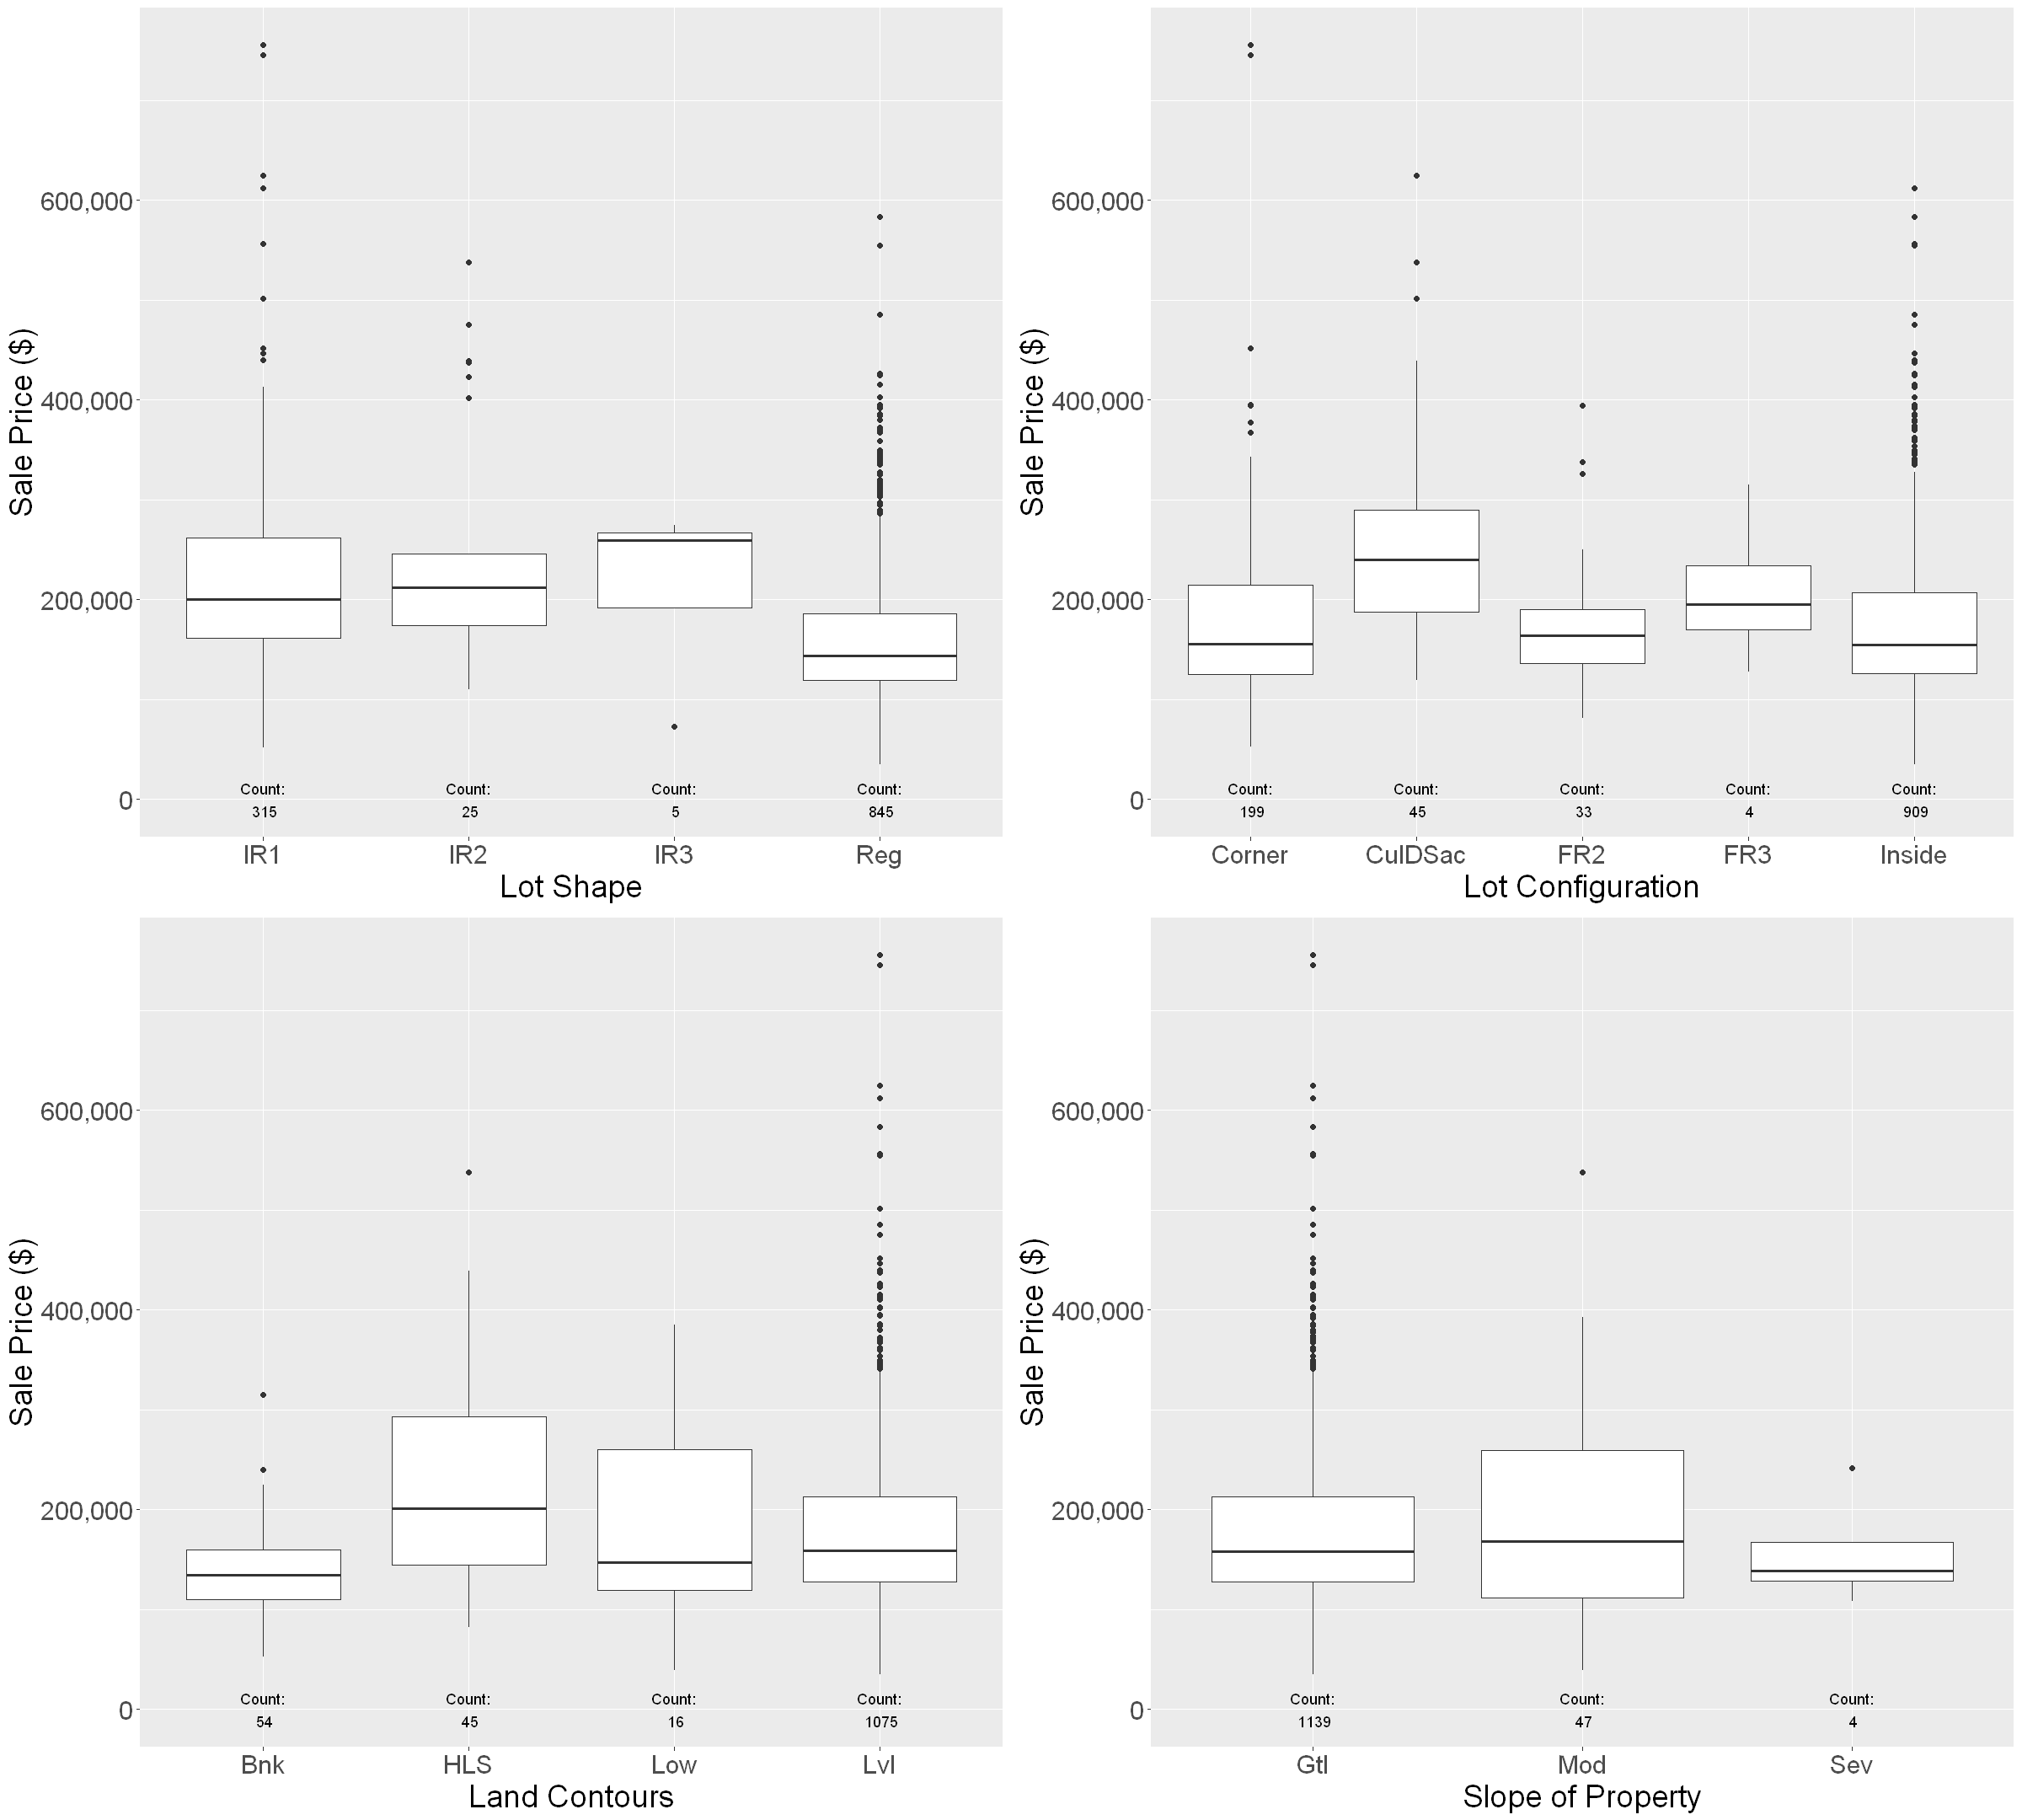

In [9]:
lot_properties <- c('LotShape', 'LotConfig', 'LandContour', 'LandSlope')
box_plots(train, lot_properties)

Lot shape and configuration both impact sale price. However, it does not appear that the qualitative degree of lot shape irregularity (IR1 -> IR2 -> IR3) affects sale price, so these levels could potentially be consolidated. Land contour might impact sale price, but the property slope does not look like it does.

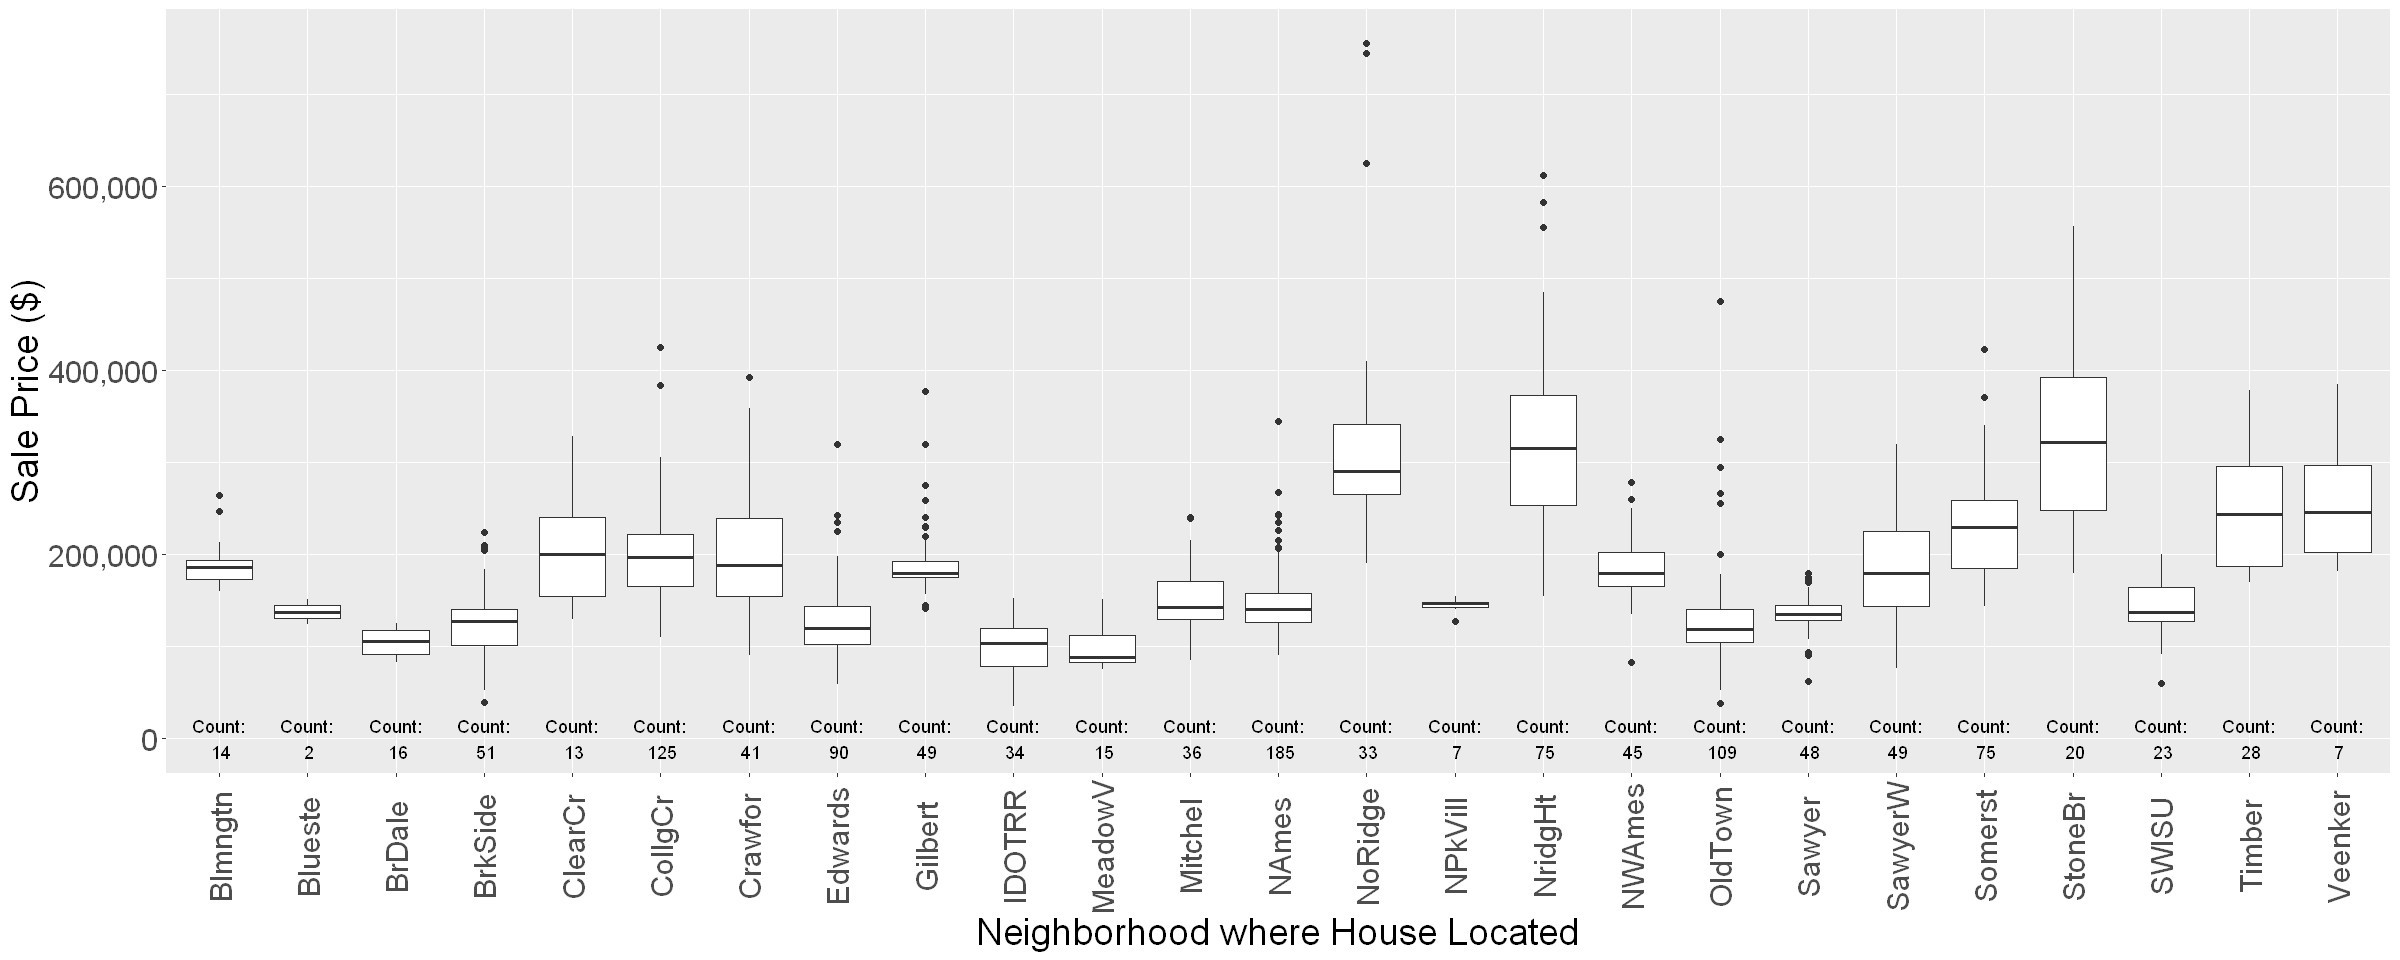

In [10]:
plot_box(train, 'Neighborhood', width = 20)

Where the house is located inside the Ames city limits clearly impacts the selling price, as several neighborhoods have greater sale prices than others.

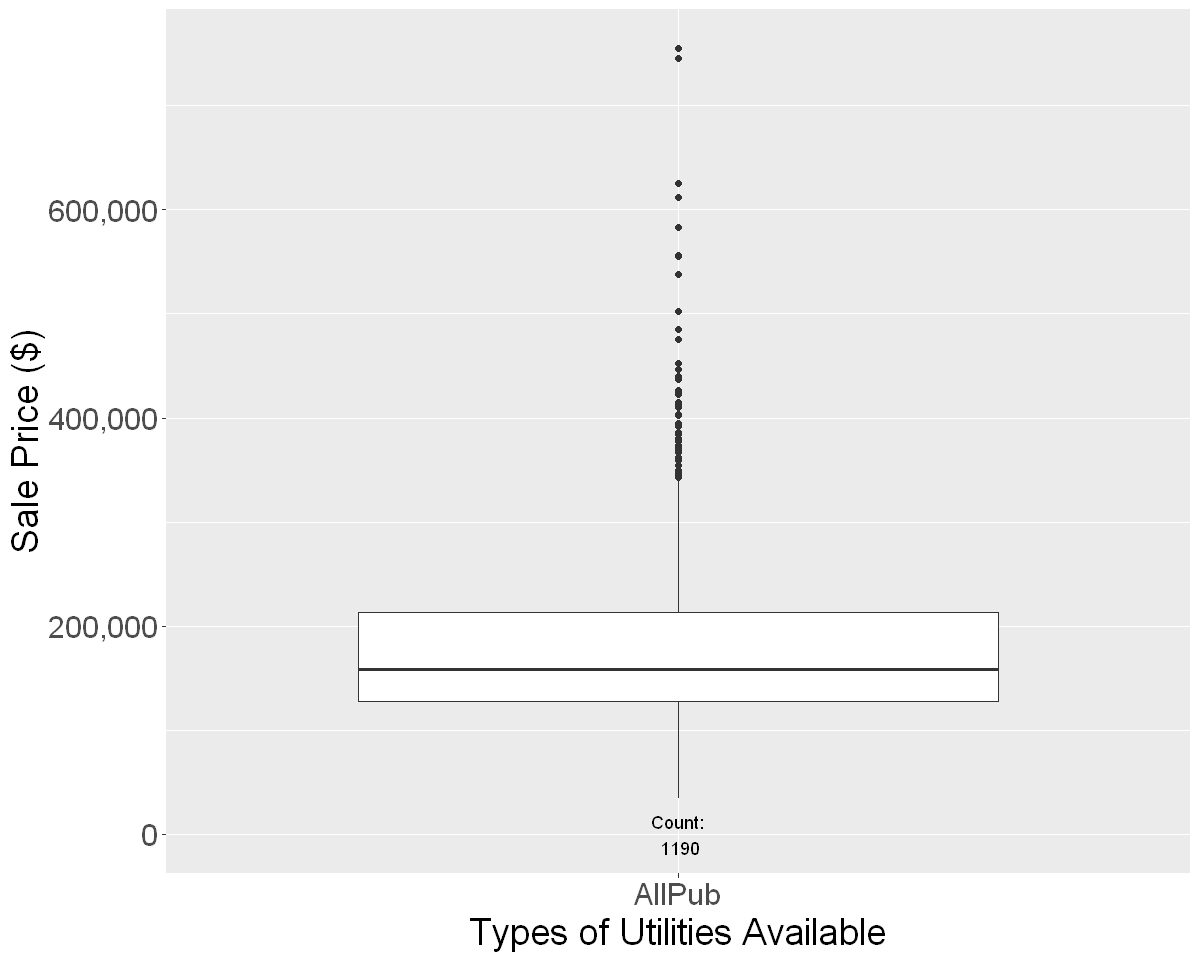

In [11]:
plot_box(train, 'Utilities')

???

There are options for other factor levels in the documentation, but they don't seem to be present...

In [12]:
train %>% count(Utilities)

Utilities,n
<chr>,<int>
AllPub,1190


...Apparently there is only a single relevant level for this feature, and it can be completely ignored.

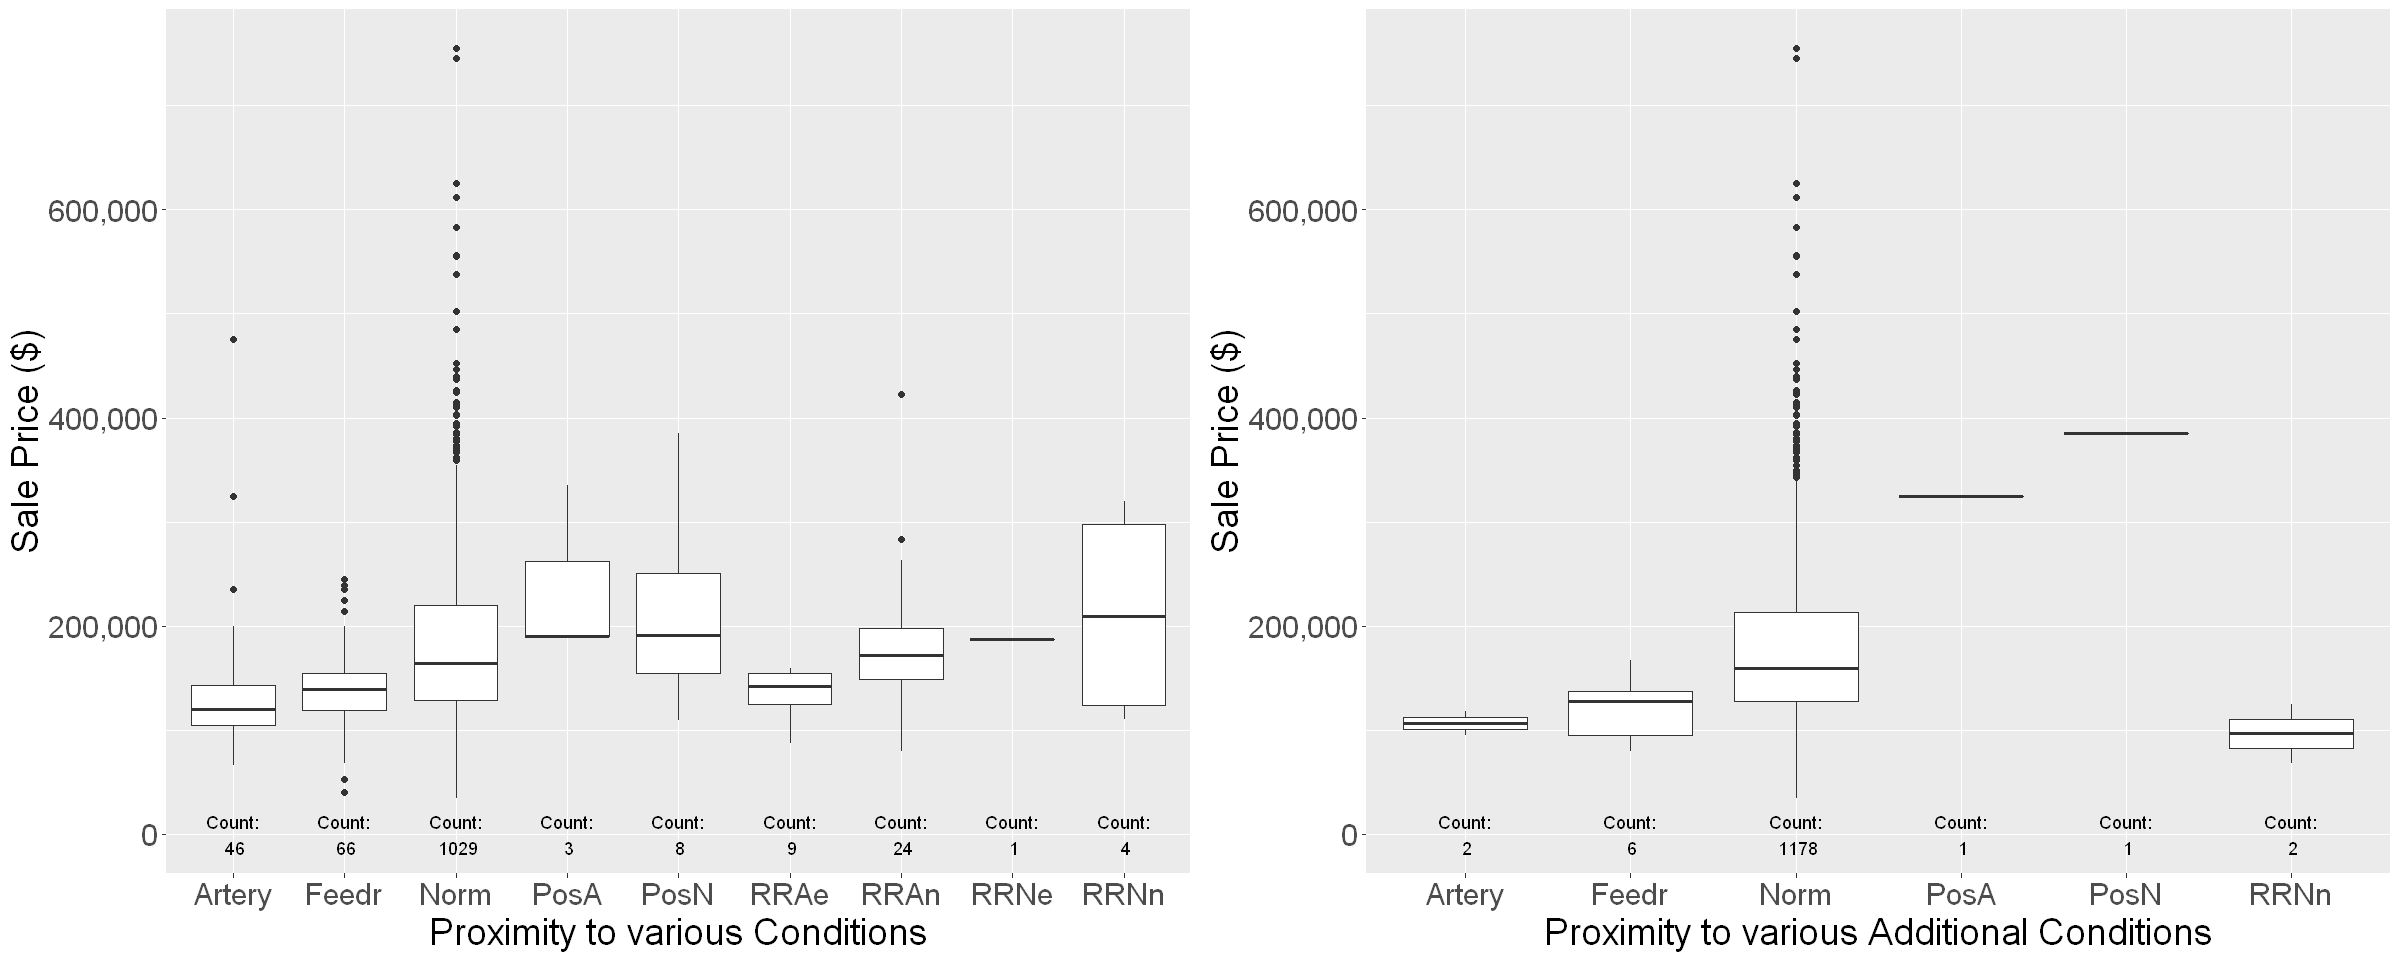

In [13]:
box_plots(train, c('Condition1','Condition2'), plot_height = 8)

It appears that some of the conditions (such as proximity to arterial or feeder streets) have a negative impact on price. There are so few properties with a second condition present that it can probably be safely ignored and only the first condition considered.

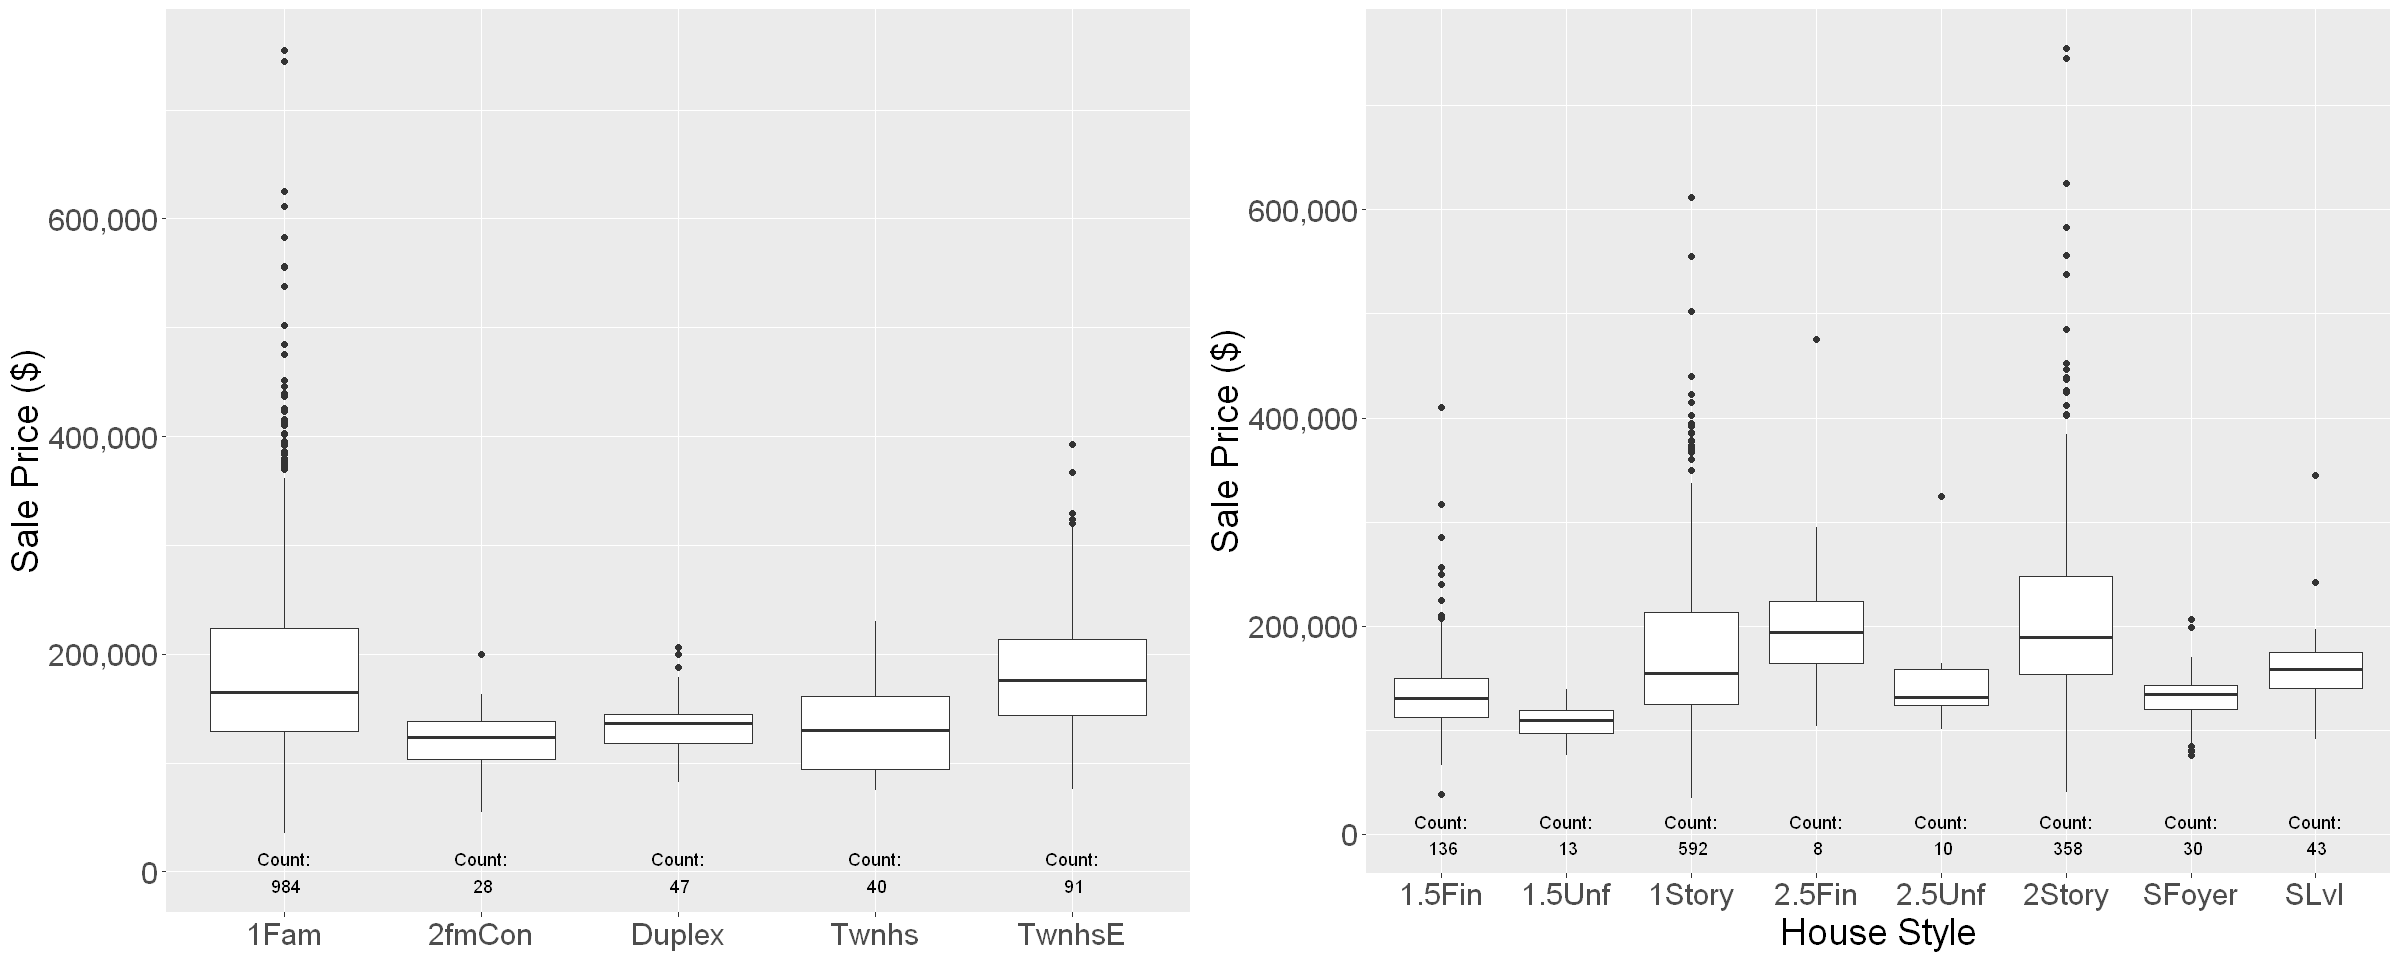

In [14]:
box_plots(train, c('BldgType','HouseStyle'), plot_height = 8)

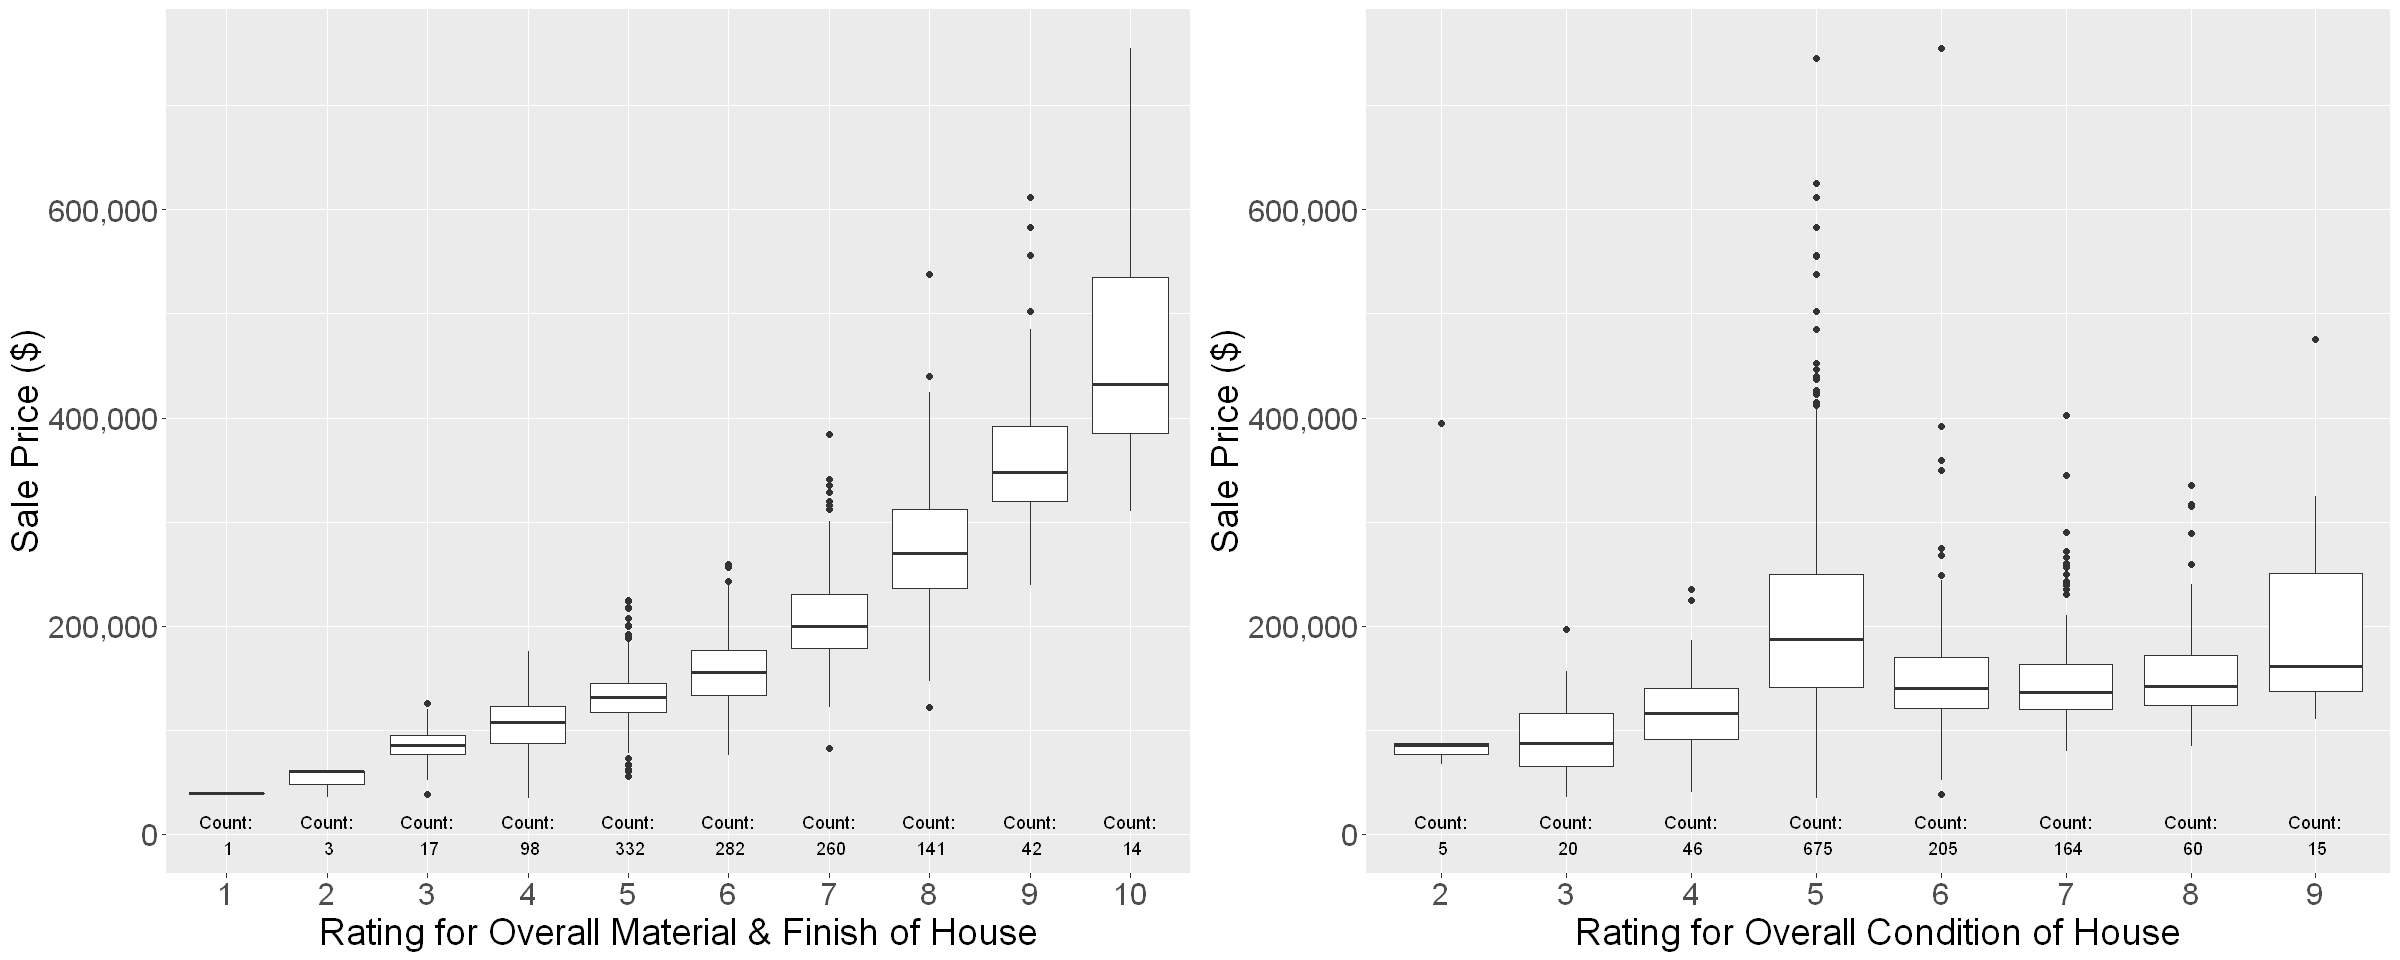

In [15]:
box_plots(train, c('OverallQual','OverallCond'), plot_height = 8)

Ratings probably aren't true categorical variables, so it is probably best not to include them in models. As would be expected, the sale price increases with the rating for the material and finish of the house. However, the rating for the overall condition for the house surprisingly does not appear to impact sale price monotonically, as would be expected. The documentation does not provide any useful information on how these ratings were obtained, so it is difficult to speculate why there is such a difference between the impacts of the two on sale price.

There are also ratings for other parts of the house (e.g. basement, kitchen, fireplaces, etc.). Since there is no available basis for these ratings and they are qualitative and possibly subjective, they will not be examined or included in any models.

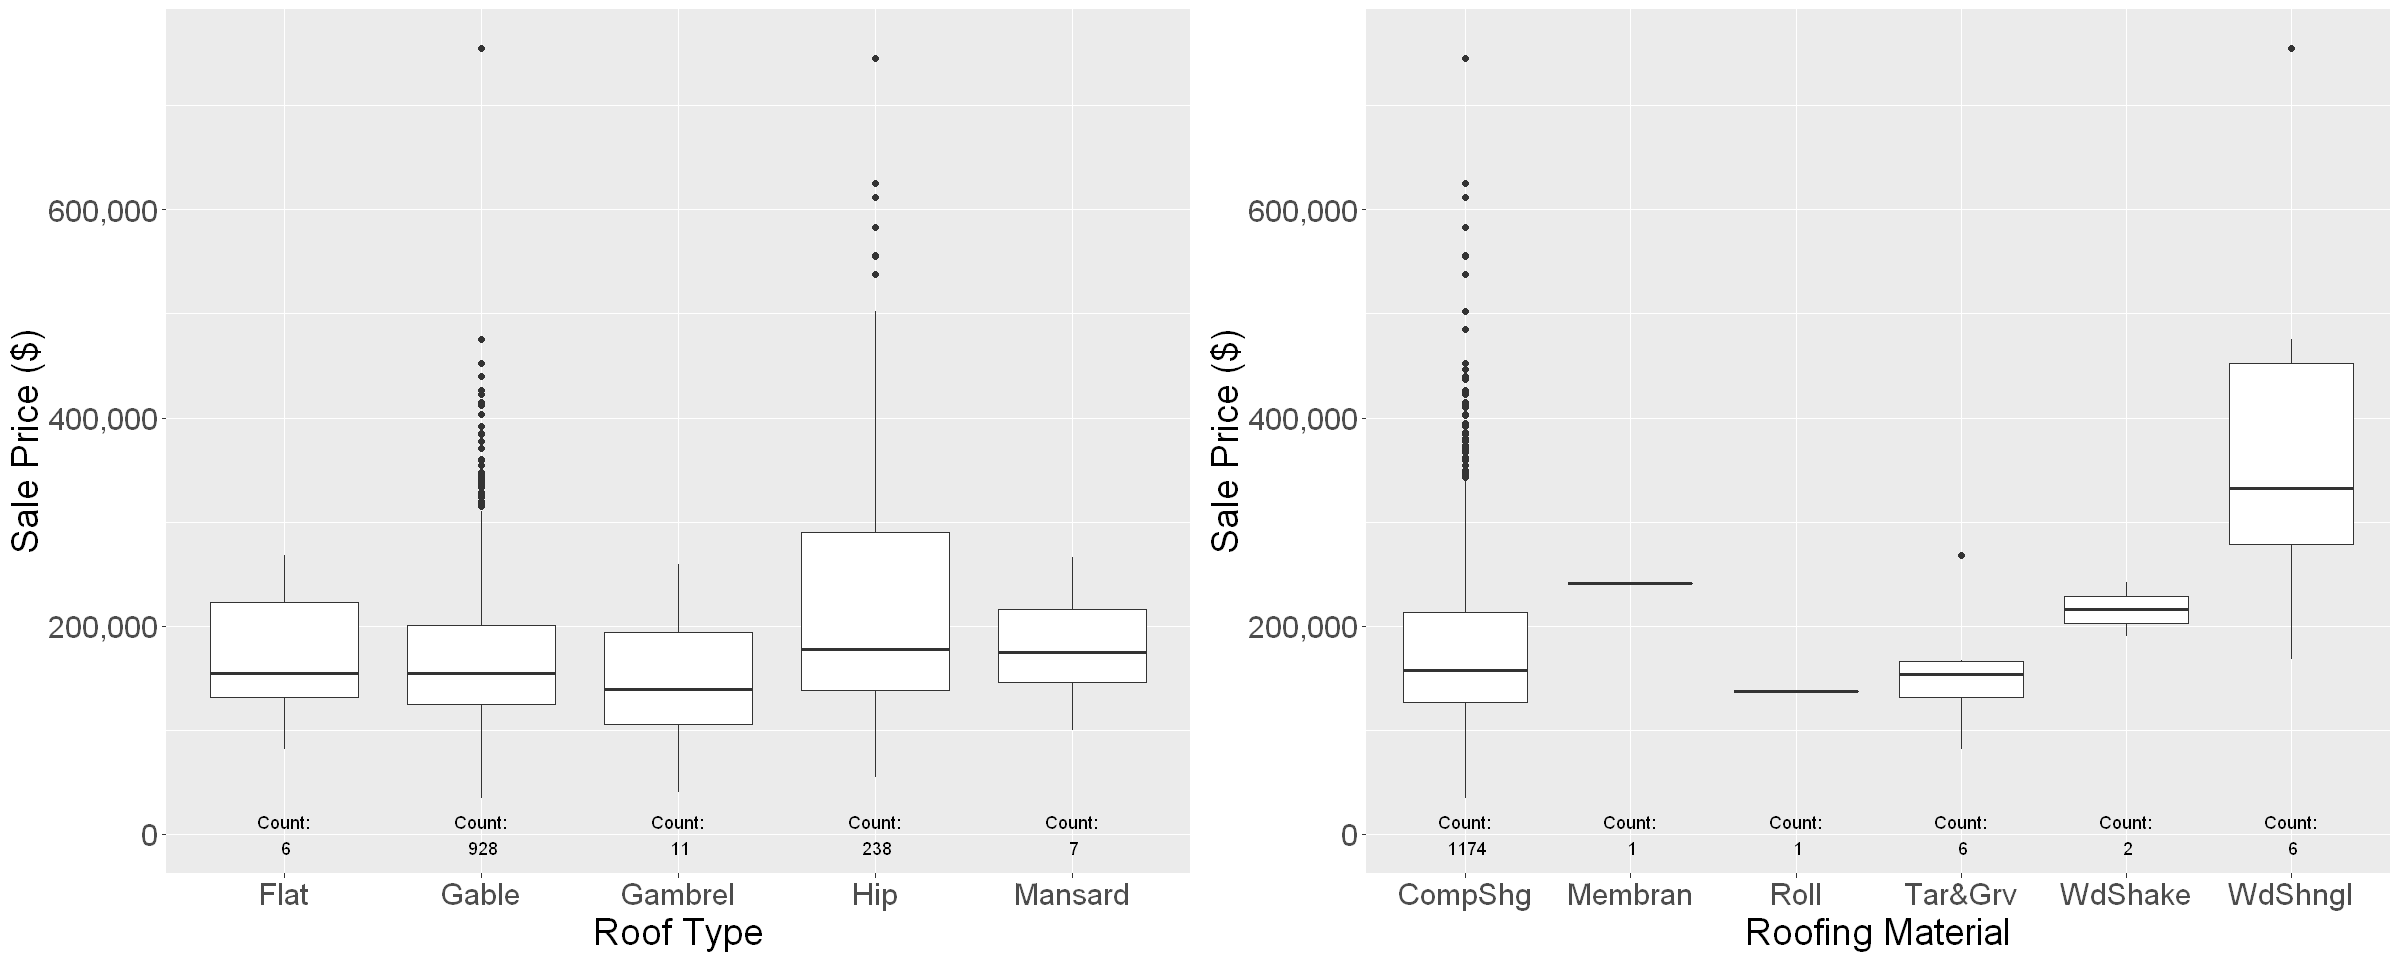

In [16]:
box_plots(train, c('RoofStyle','RoofMatl'), plot_height = 8)

Almost all of the house roofs are comprised of composite shingles, so there is probably an insufficient quantity of the other materials for this feature to be relevant. The shape of the roof appears like it may have an impact on the distribution of the house sale prices.

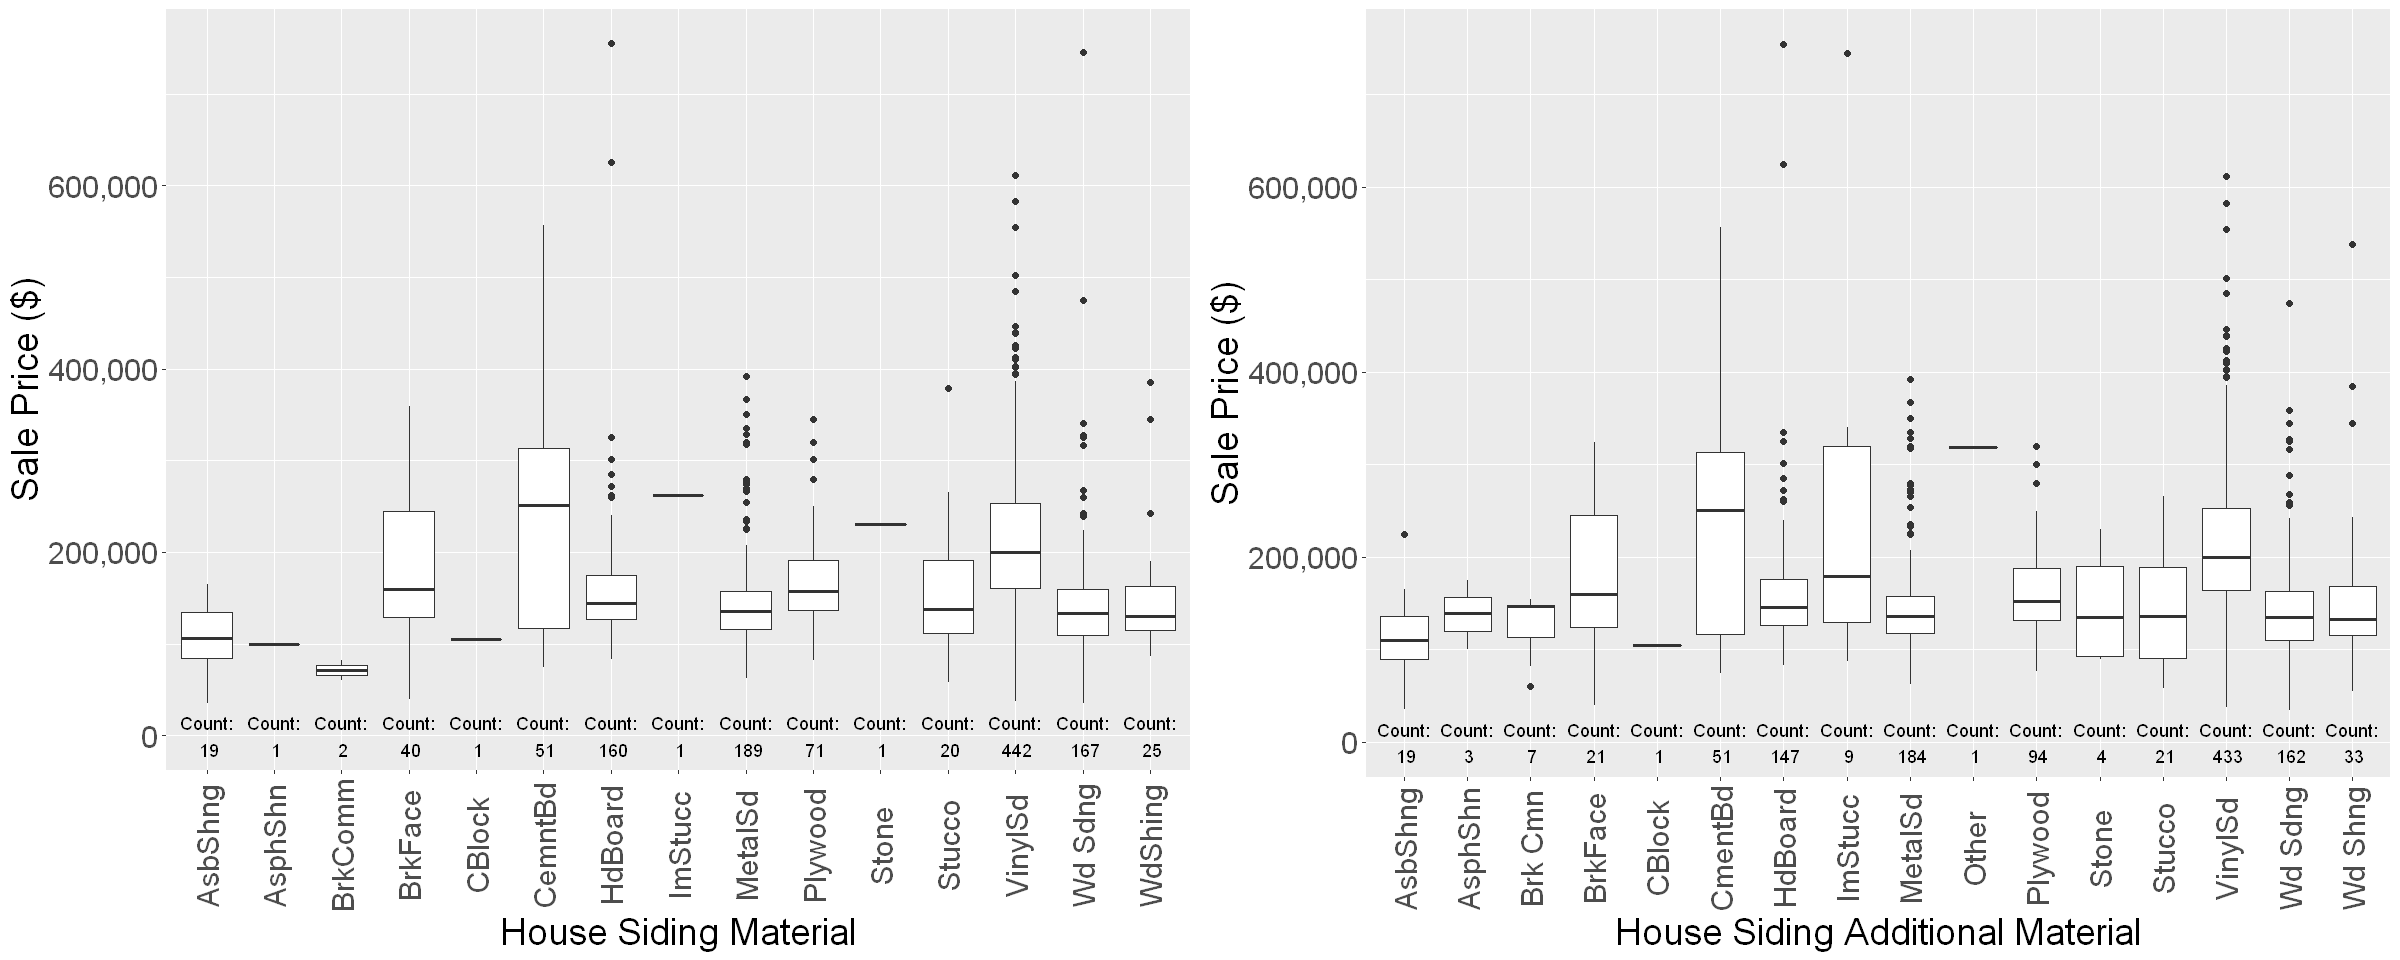

In [17]:
box_plots(train, c('Exterior1st','Exterior2nd'), plot_height = 8)

There is something strange with the house siding features. The second feature is supposedly for additional house siding material ("if more than one material"). However, the distributions of both features look similar. It's almost like the values for these two features overlap...

In [18]:
train %>% filter(Exterior1st == Exterior2nd) %>% count

n
<int>
1015


...which they apparently do. This will have accounted for before incorporation into a model. Now, plotting only the houses that actually have a distinct second building material:

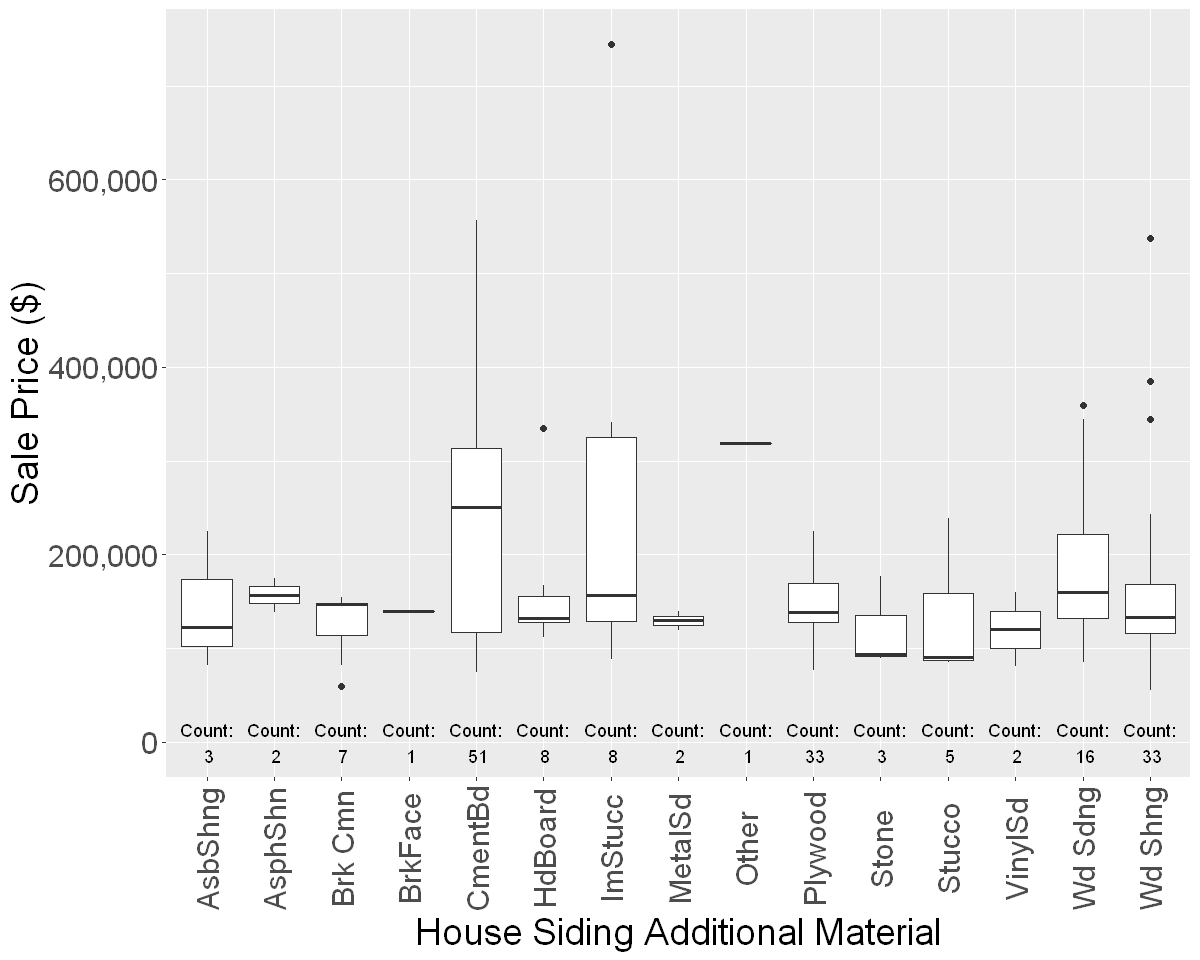

In [19]:
plot_box(train %>% filter(Exterior1st != Exterior2nd), 'Exterior2nd')

The secondary siding material may or may not have an impact on house price beyond the impacts of the primary material; it's unclear at this stage, but should become apparent when beginning regression analysis.

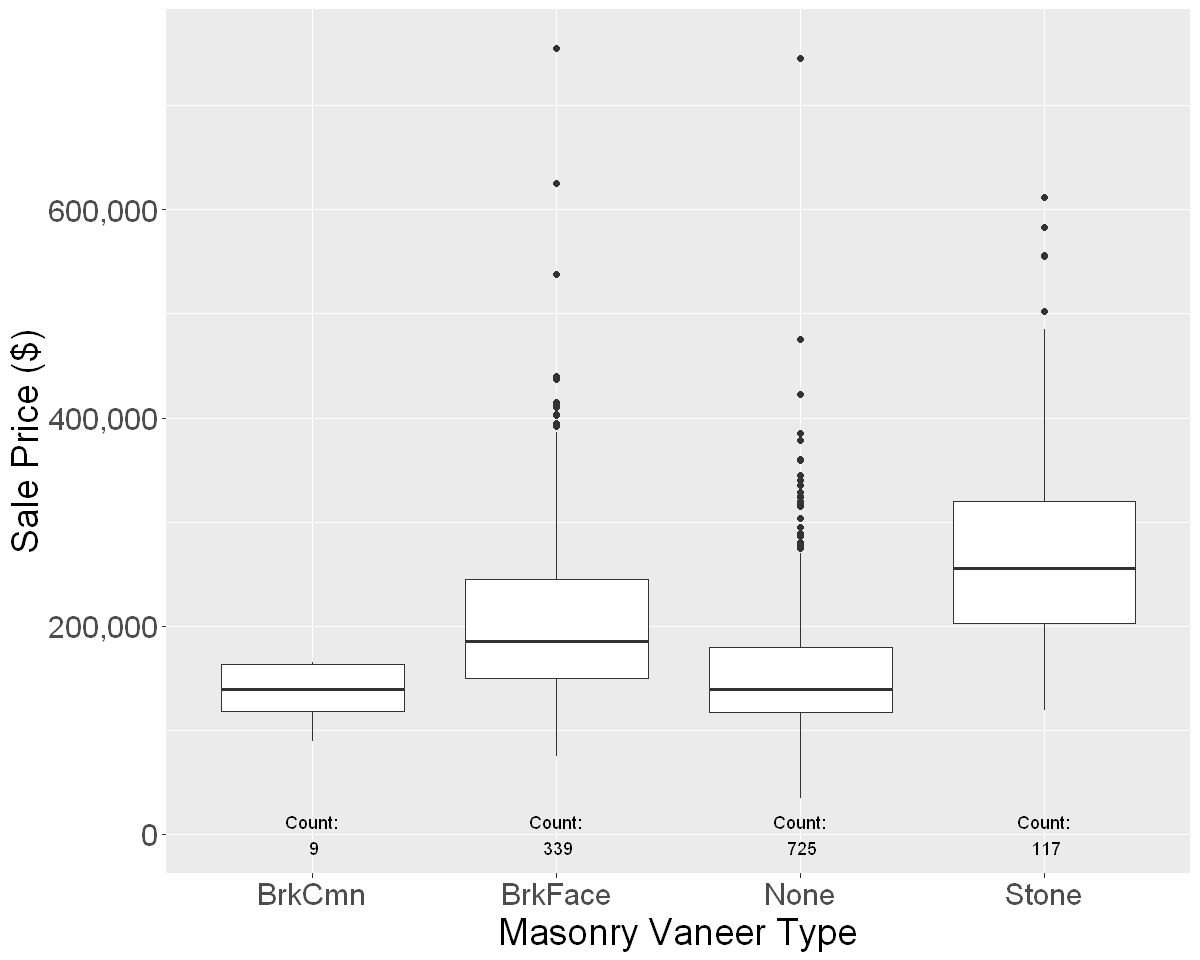

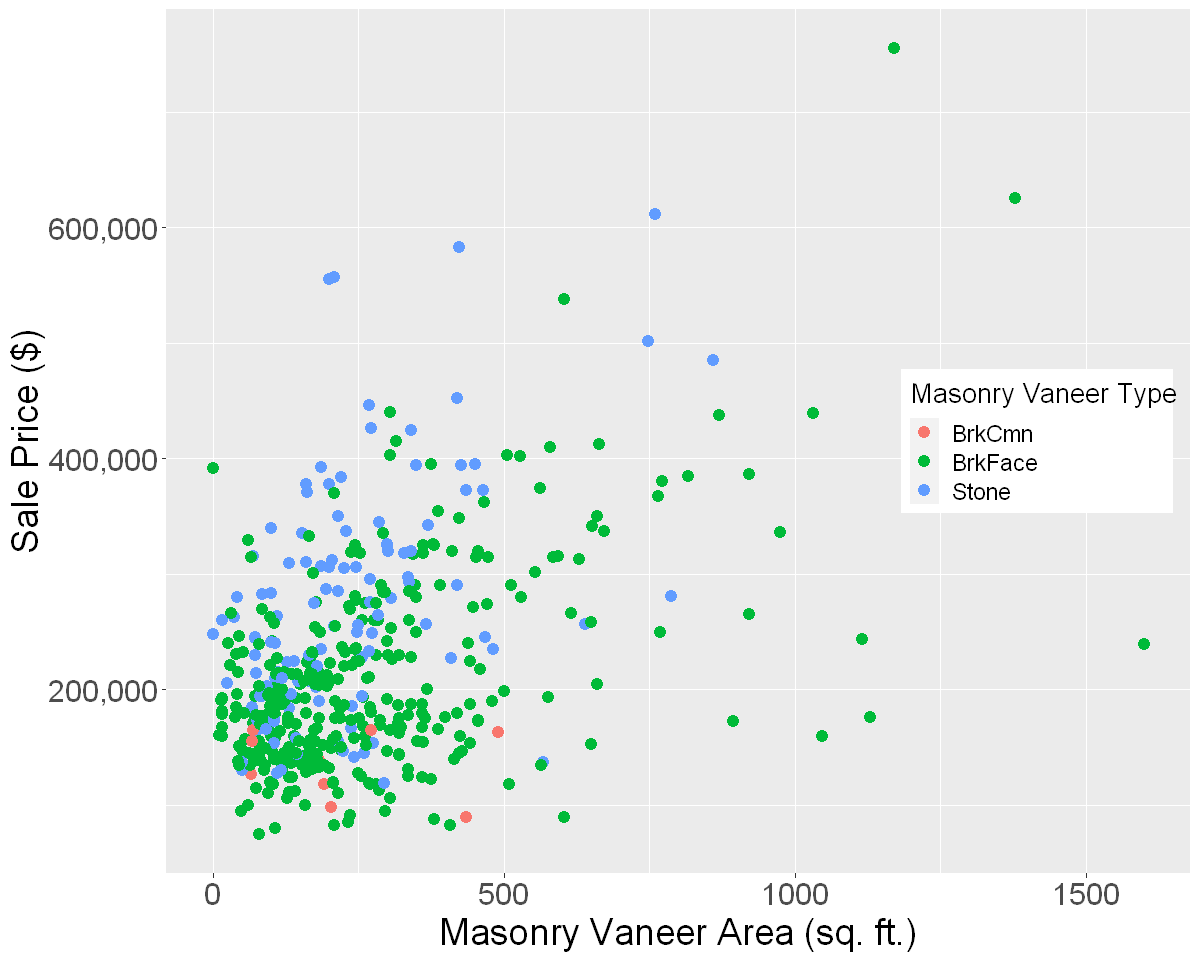

In [20]:
plot_box(train, 'MasVnrType')
# MasVnrArea (Masonry Area) is a continous variable, but is only relevant when there is masonry present (e.g. MasVnrType =/= None)
# Its analysis was skipped in Part 2 of EDA because, but now it is worth checking to see if the masonry area can impact sale price
# The scatter plot function from Part 2 will be reused, with a small modification
plot_scatter <- function(data, x_column, y_column = 'SalePrice', factor_column = 'MasVnrType', width = 10, height = 8) {
    options(repr.plot.width = width, repr.plot.height = height)
    sctr_plot <- ggplot(data, aes(x = !!sym(x_column), y = !!sym(y_column))) +
      geom_point(size = 3, aes(colour = factor(!!sym(factor_column)))) + #add the masonry type as a factor to see if there is any confounding with masonry type and area
      labs(x = axis_label(x_column), y = axis_label(y_column), color = axis_label(factor_column)) +
      theme(axis.title = element_text(size = 22),
            axis.text = element_text(size = 18),
            legend.position = c(0.85, 0.5),
            legend.title = element_text(size = 16),
            legend.text = element_text(size = 14))
    lrg_val <- c('SalePrice','LotArea','GrLivArea','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','GarageArea')
    if (x_column %in% lrg_val) {
        sctr_plot_x <- sctr_plot + scale_x_continuous(label = label_comma())
    } else {
        sctr_plot_x <- sctr_plot
    }
    if (y_column %in% lrg_val) {
        sctr_plot_y <- sctr_plot_x + scale_y_continuous(label = label_comma())
    } else {
        sctr_plot_y <- sctr_plot_x
    }
    return(sctr_plot_y)
}
plot_scatter(train %>% filter(MasVnrType != 'None'), 'MasVnrArea')

The presence and different types of masonry on the house impact the sale price. It looks like there may be a weak correlation between masonry vaneer area and sale price.

In [21]:
# Reuse function to evaluate correlation coefficient between SalePrice and other features from Part 2 of EDA
scatter_correl <- function(data, columns) {
  for (column in columns) {
    correl <- data %>%
      select(SalePrice, all_of(column)) %>%
      corr()
    cat('The correlation coefficient between Sale Price &', axis_label(column), 'is', round(correl, digits = 3),'\n')
  }
}
scatter_correl(train, 'MasVnrArea')

The correlation coefficient between Sale Price & Masonry Vaneer Area (sq. ft.) is 0.506 


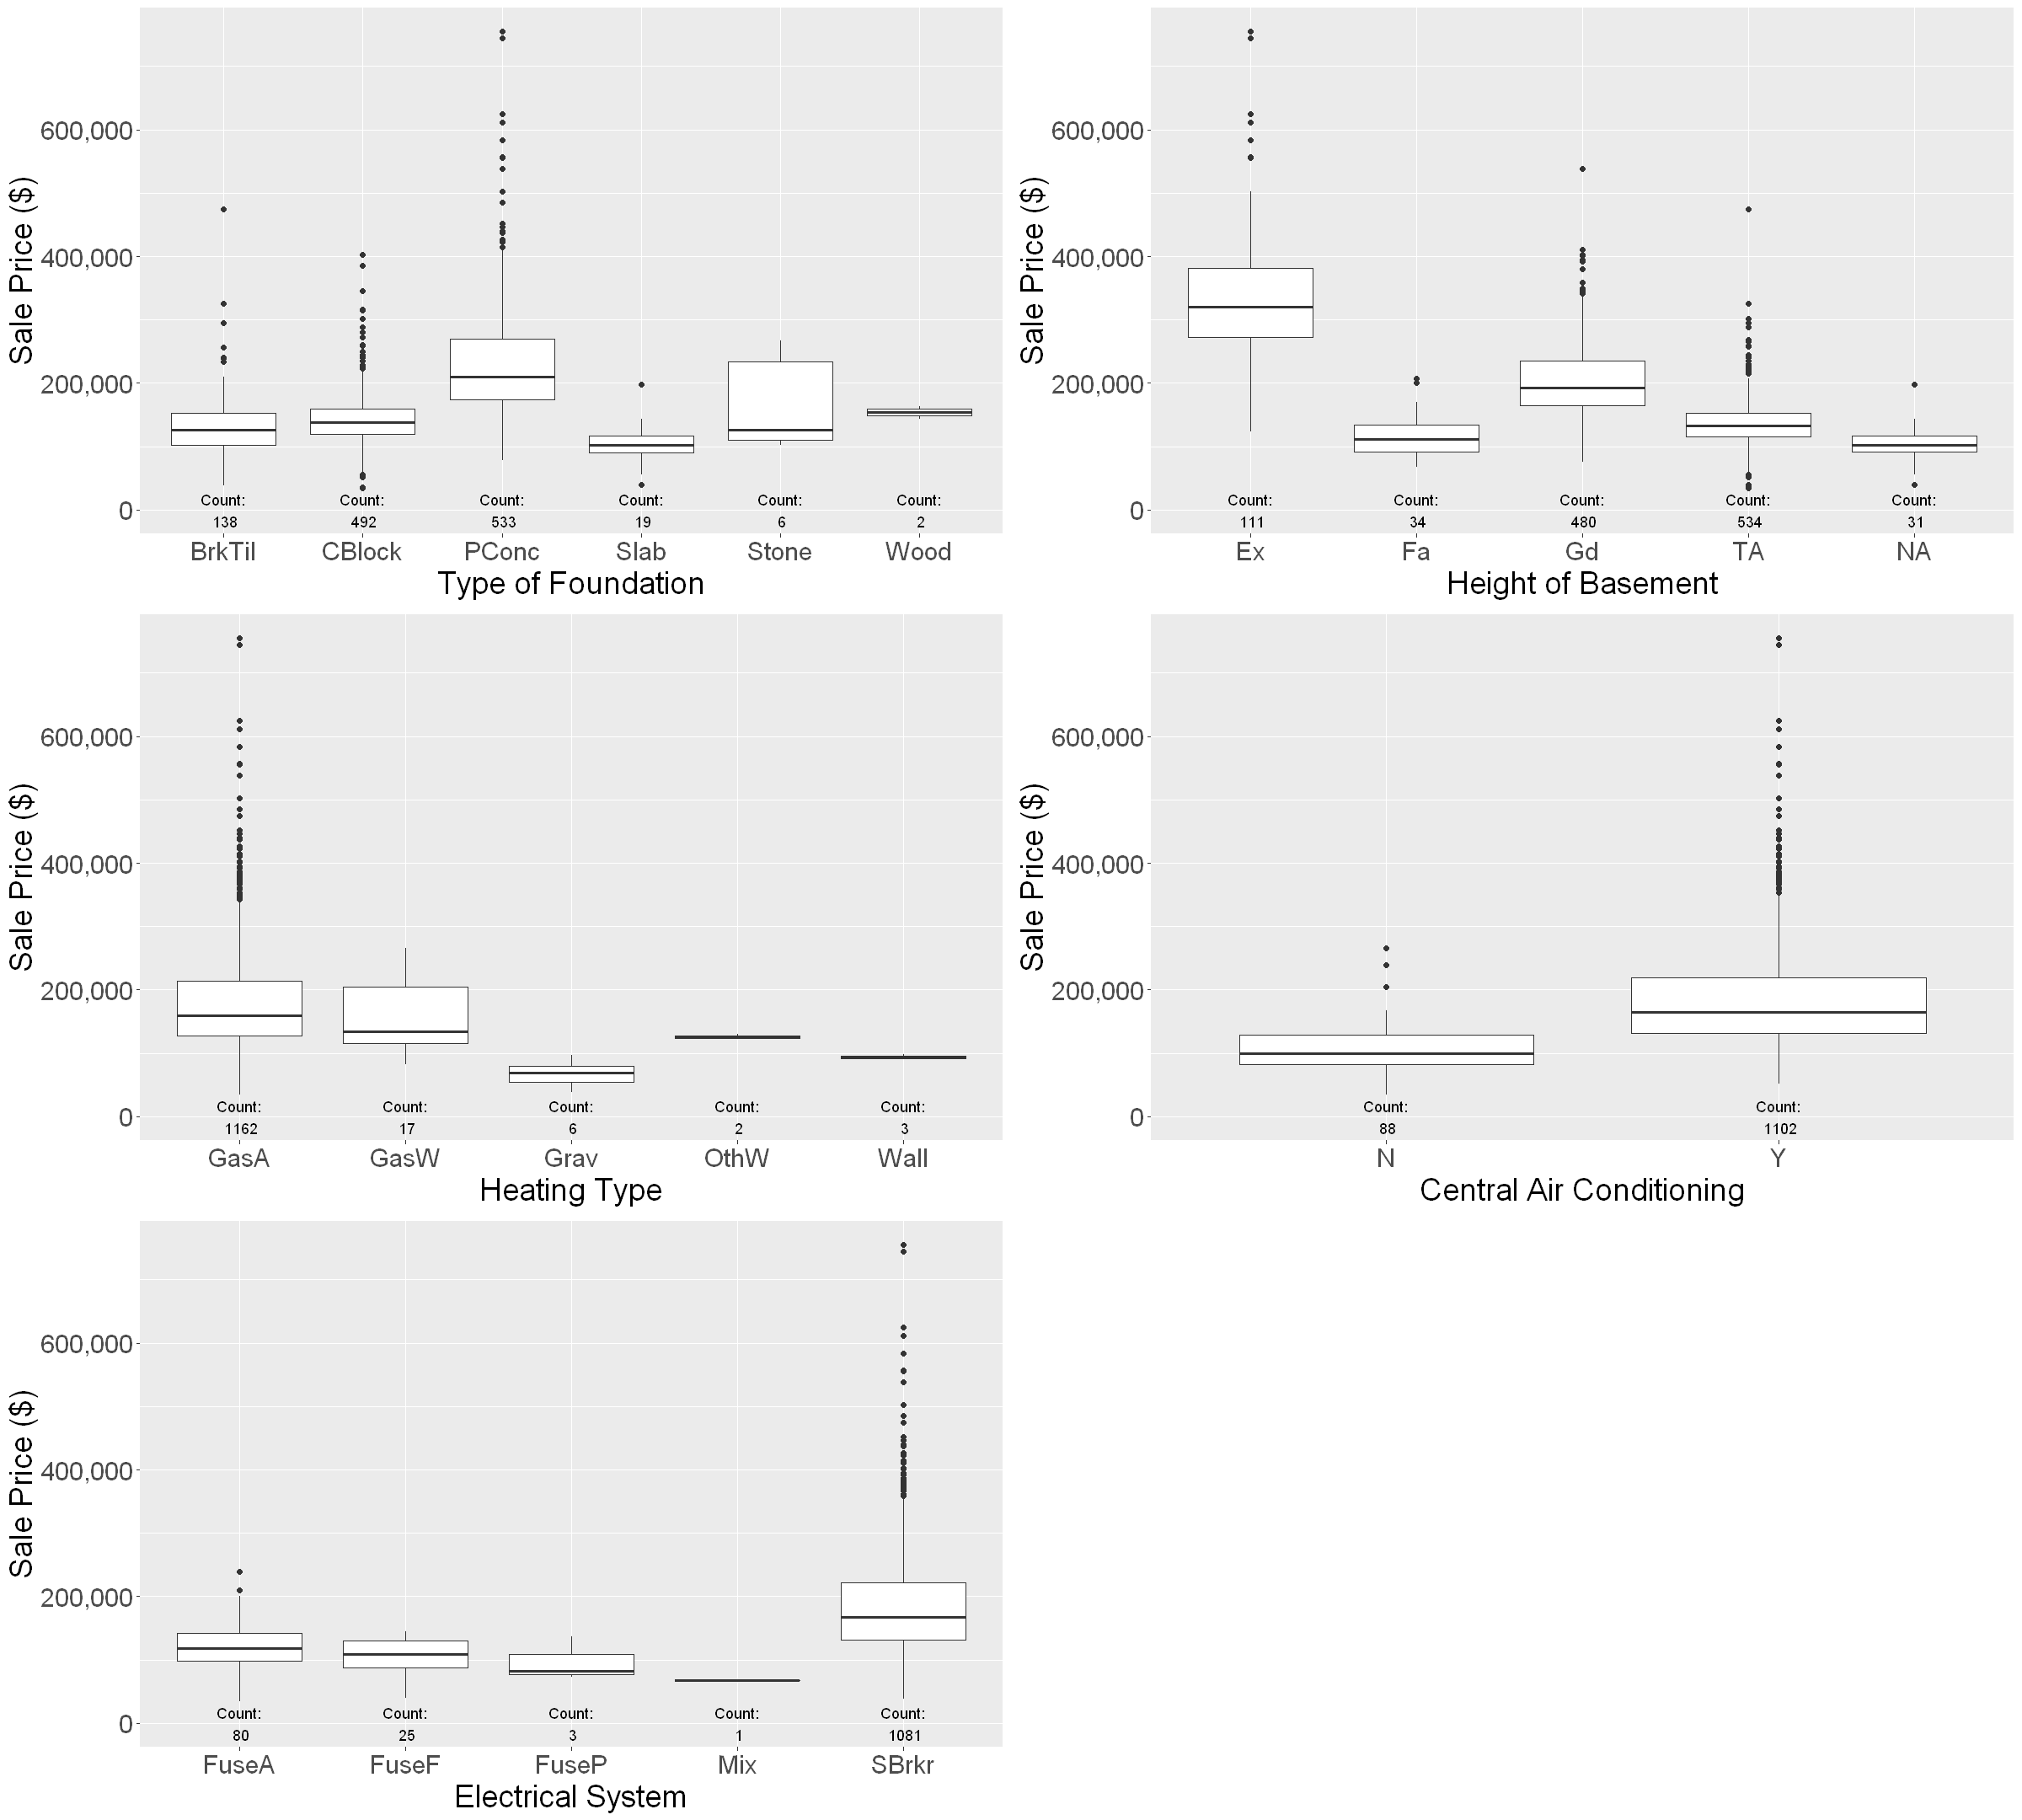

In [22]:
found_base_util <- c('Foundation', 'BsmtQual', 'Heating', 'CentralAir', 'Electrical')
box_plots(train, found_base_util)

Looking at foundation type, there is a clear impact of what the foundation material is on sale price. Likewise, the height of the basement also impacts sale price (presumably related to the usability of the basement.

Let's also consider the heating, cooling, and the home electrical systems. Almost all of the homes have gas-heated forced air, so this feature can probably be ignored. Most homes also have central air conditioning, although those without appear to have noticeably lower sale prices, so this is probably relevant for a model. Lastly, whether the house had circuit breakers or fuses appears to impact sale price, and the different types of fuses could probably be combined into a single type for a model.

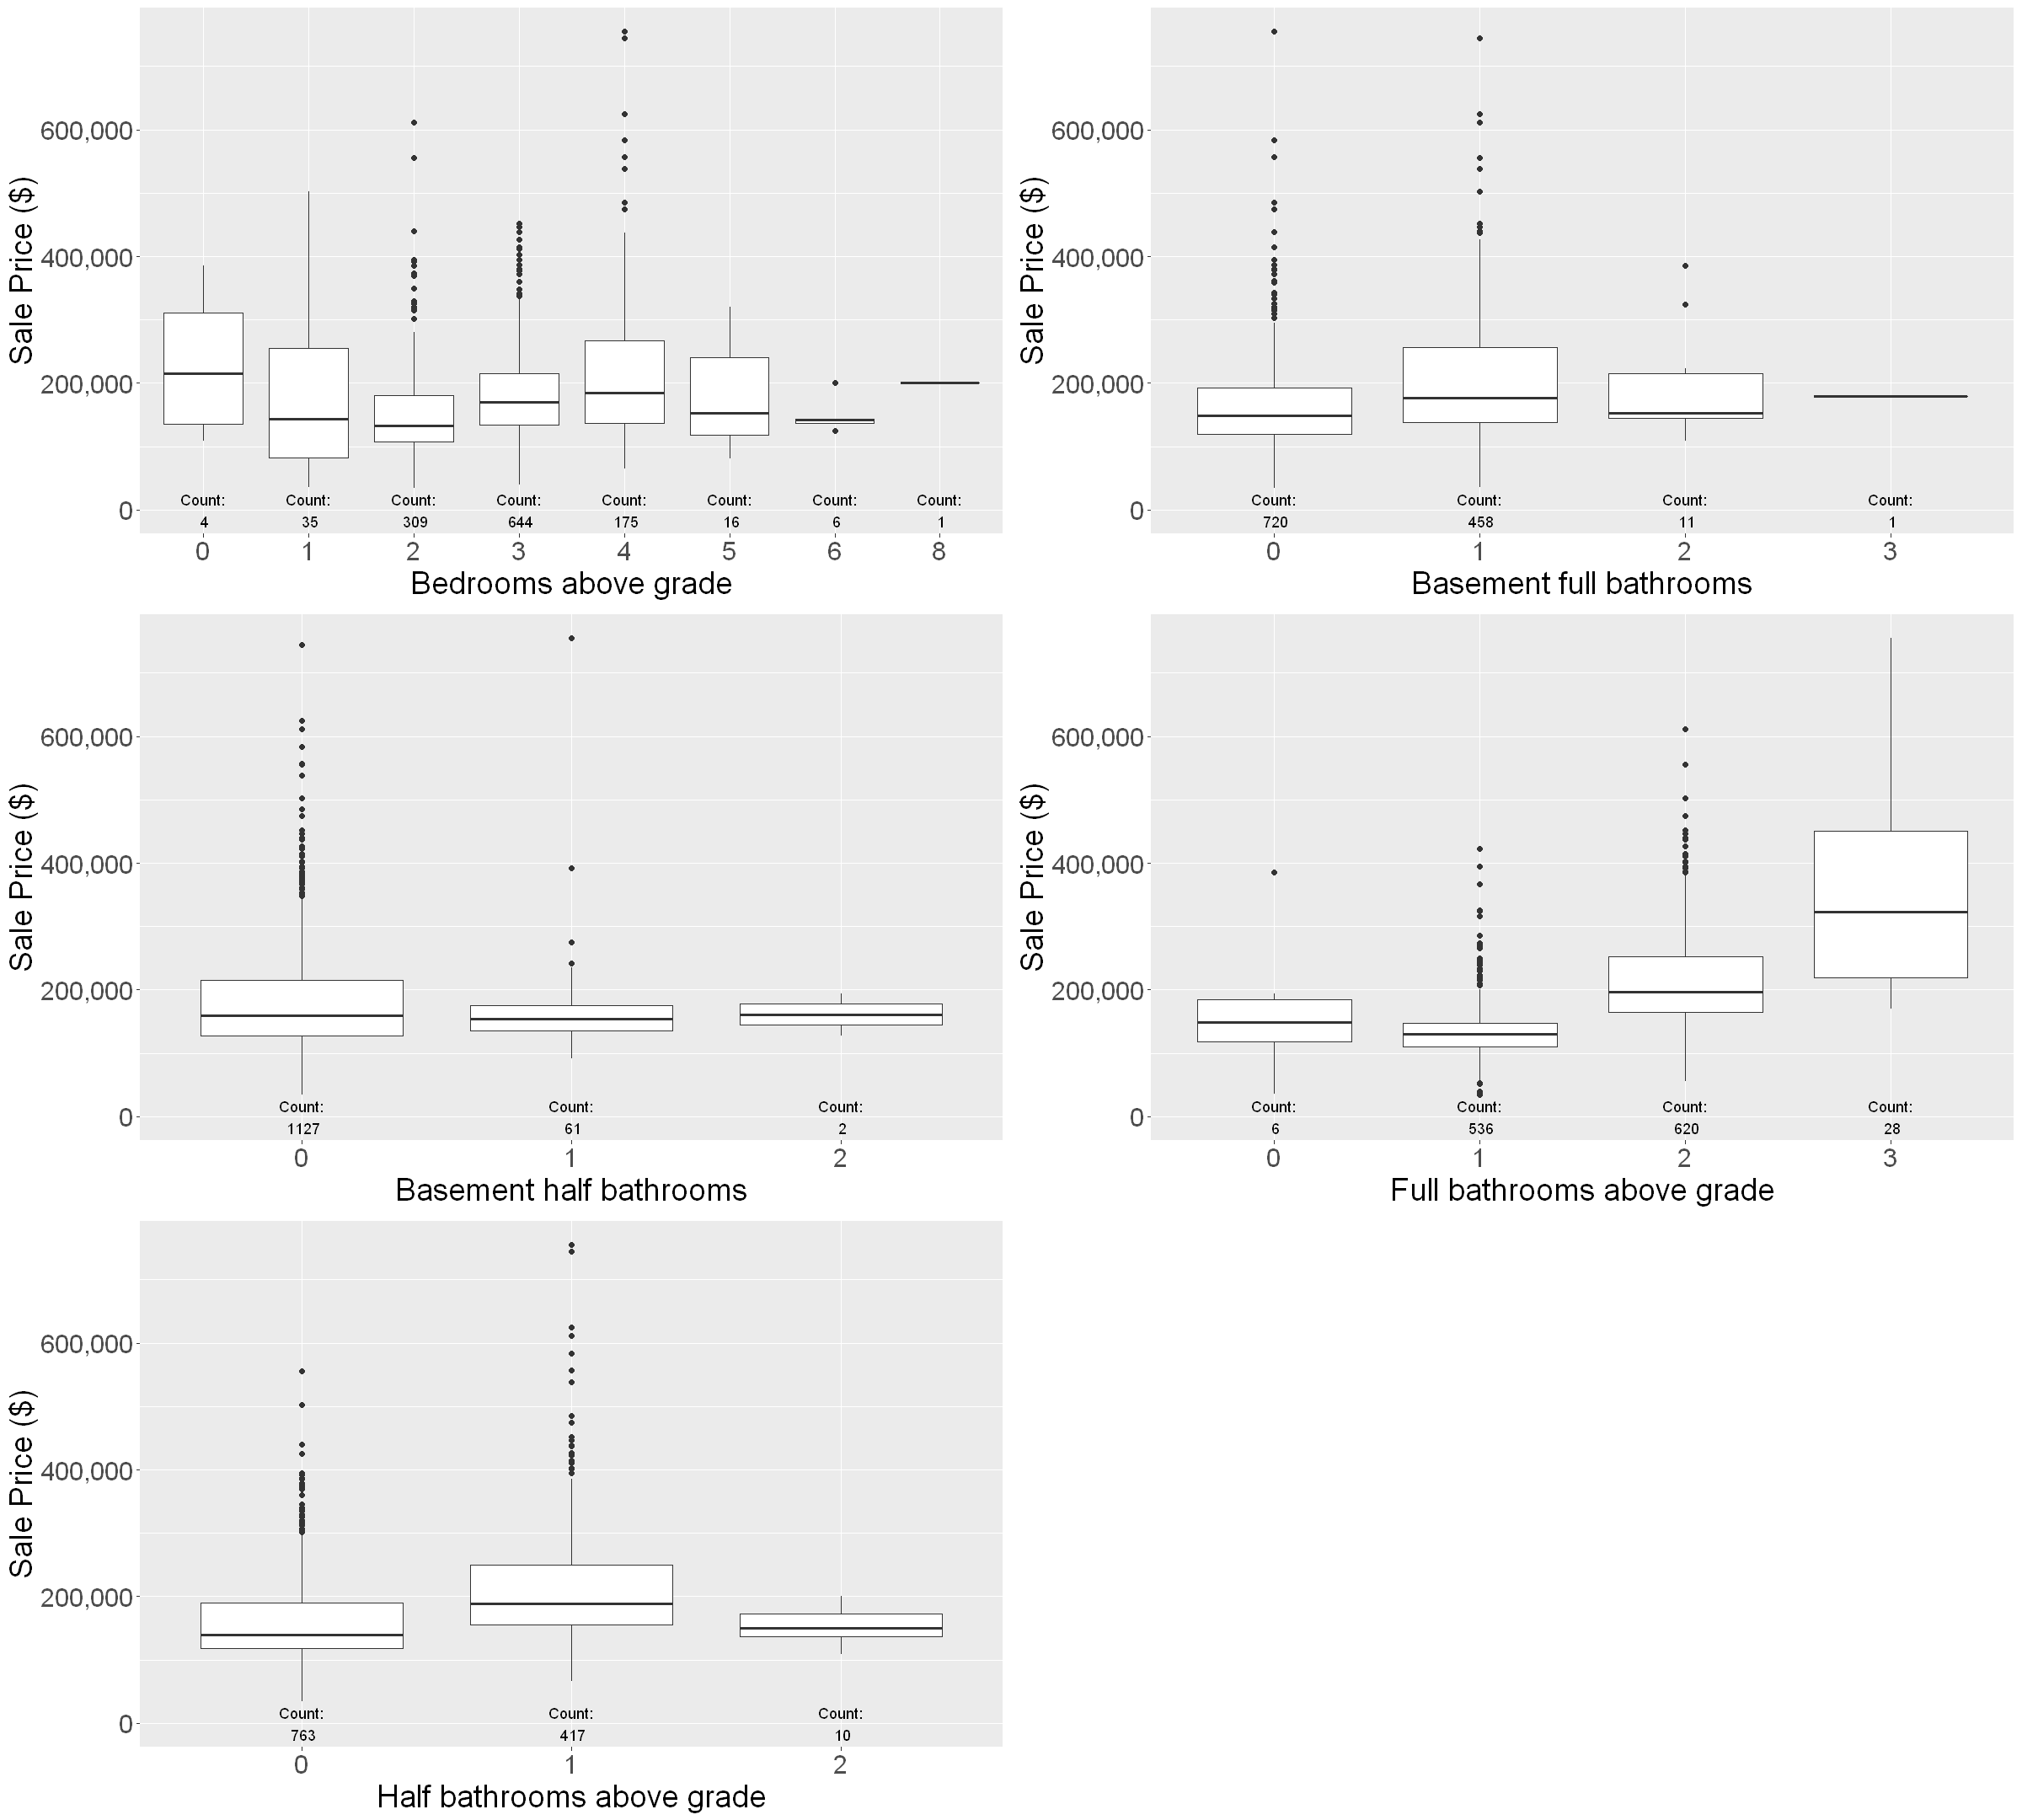

In [23]:
bed_bath <- c('BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath')
box_plots(train, bed_bath)

The number of bedrooms and bathrooms should intuitively impact sale price, as these are some of the most frequented rooms in a home. The number of above grade bedrooms, however, does not appear to have a major impact on the sale price of the home. There is a much large impact from the number of full bathrooms that are above grade. Half bathrooms and any bathroom located in the basement appear to have no impact whatsoever on the sale price, and can probably be ignored.

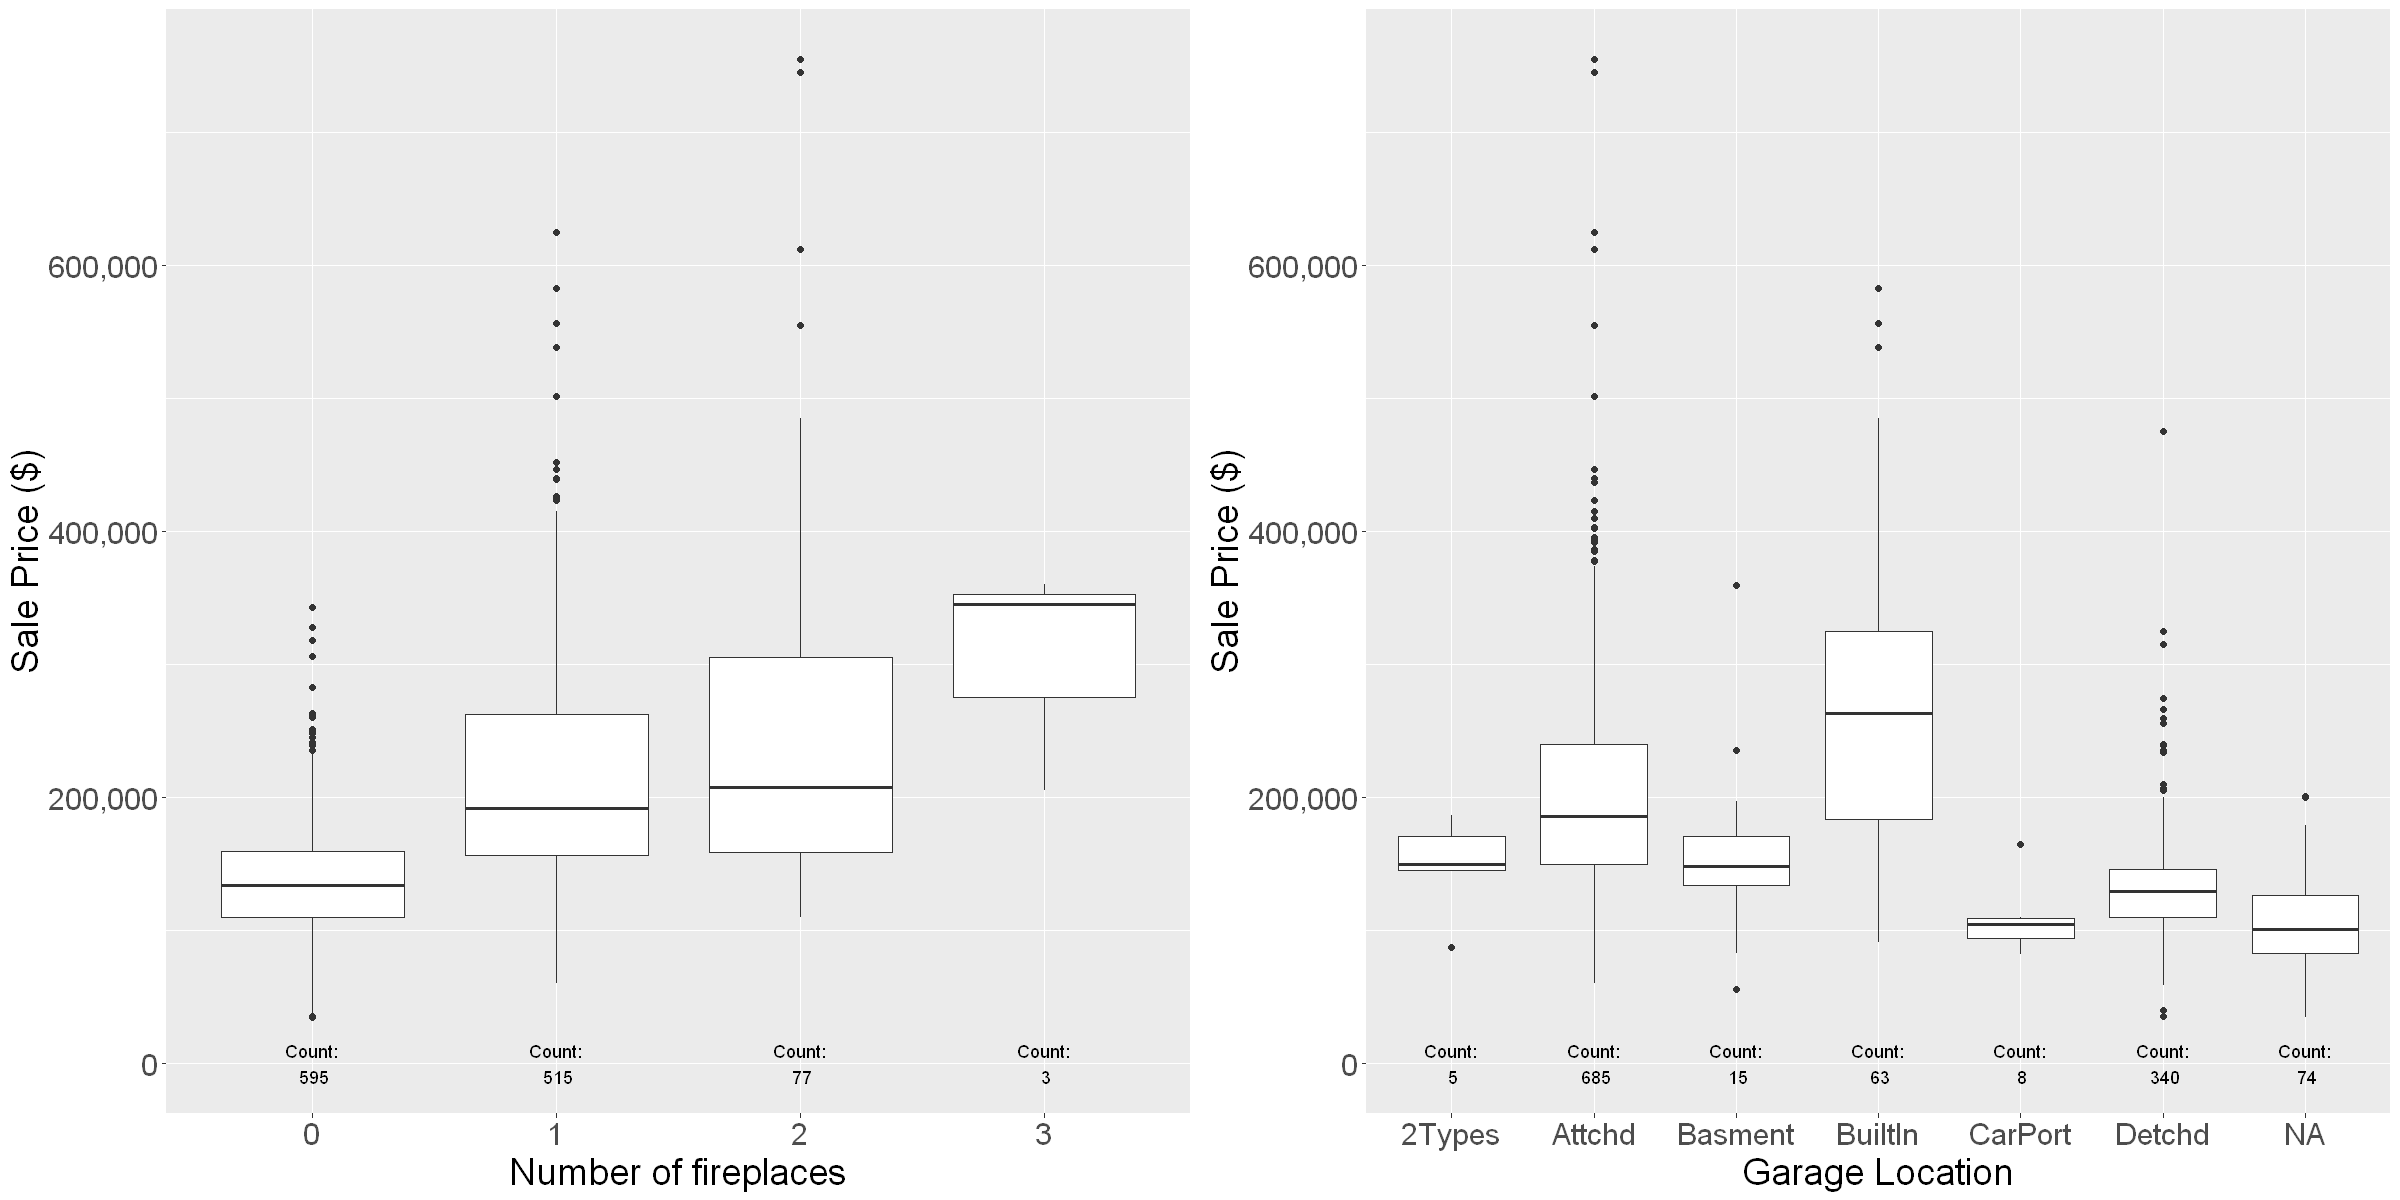

In [24]:
fireplace_garageloc <- c('Fireplaces', 'GarageType')
box_plots(train, fireplace_garageloc, plot_height = 10)

The presence or absence of fireplaces seems to impact the sale price, but the impace appears limited after the first fireplace.

The location of garage clearly impacts the sale price.

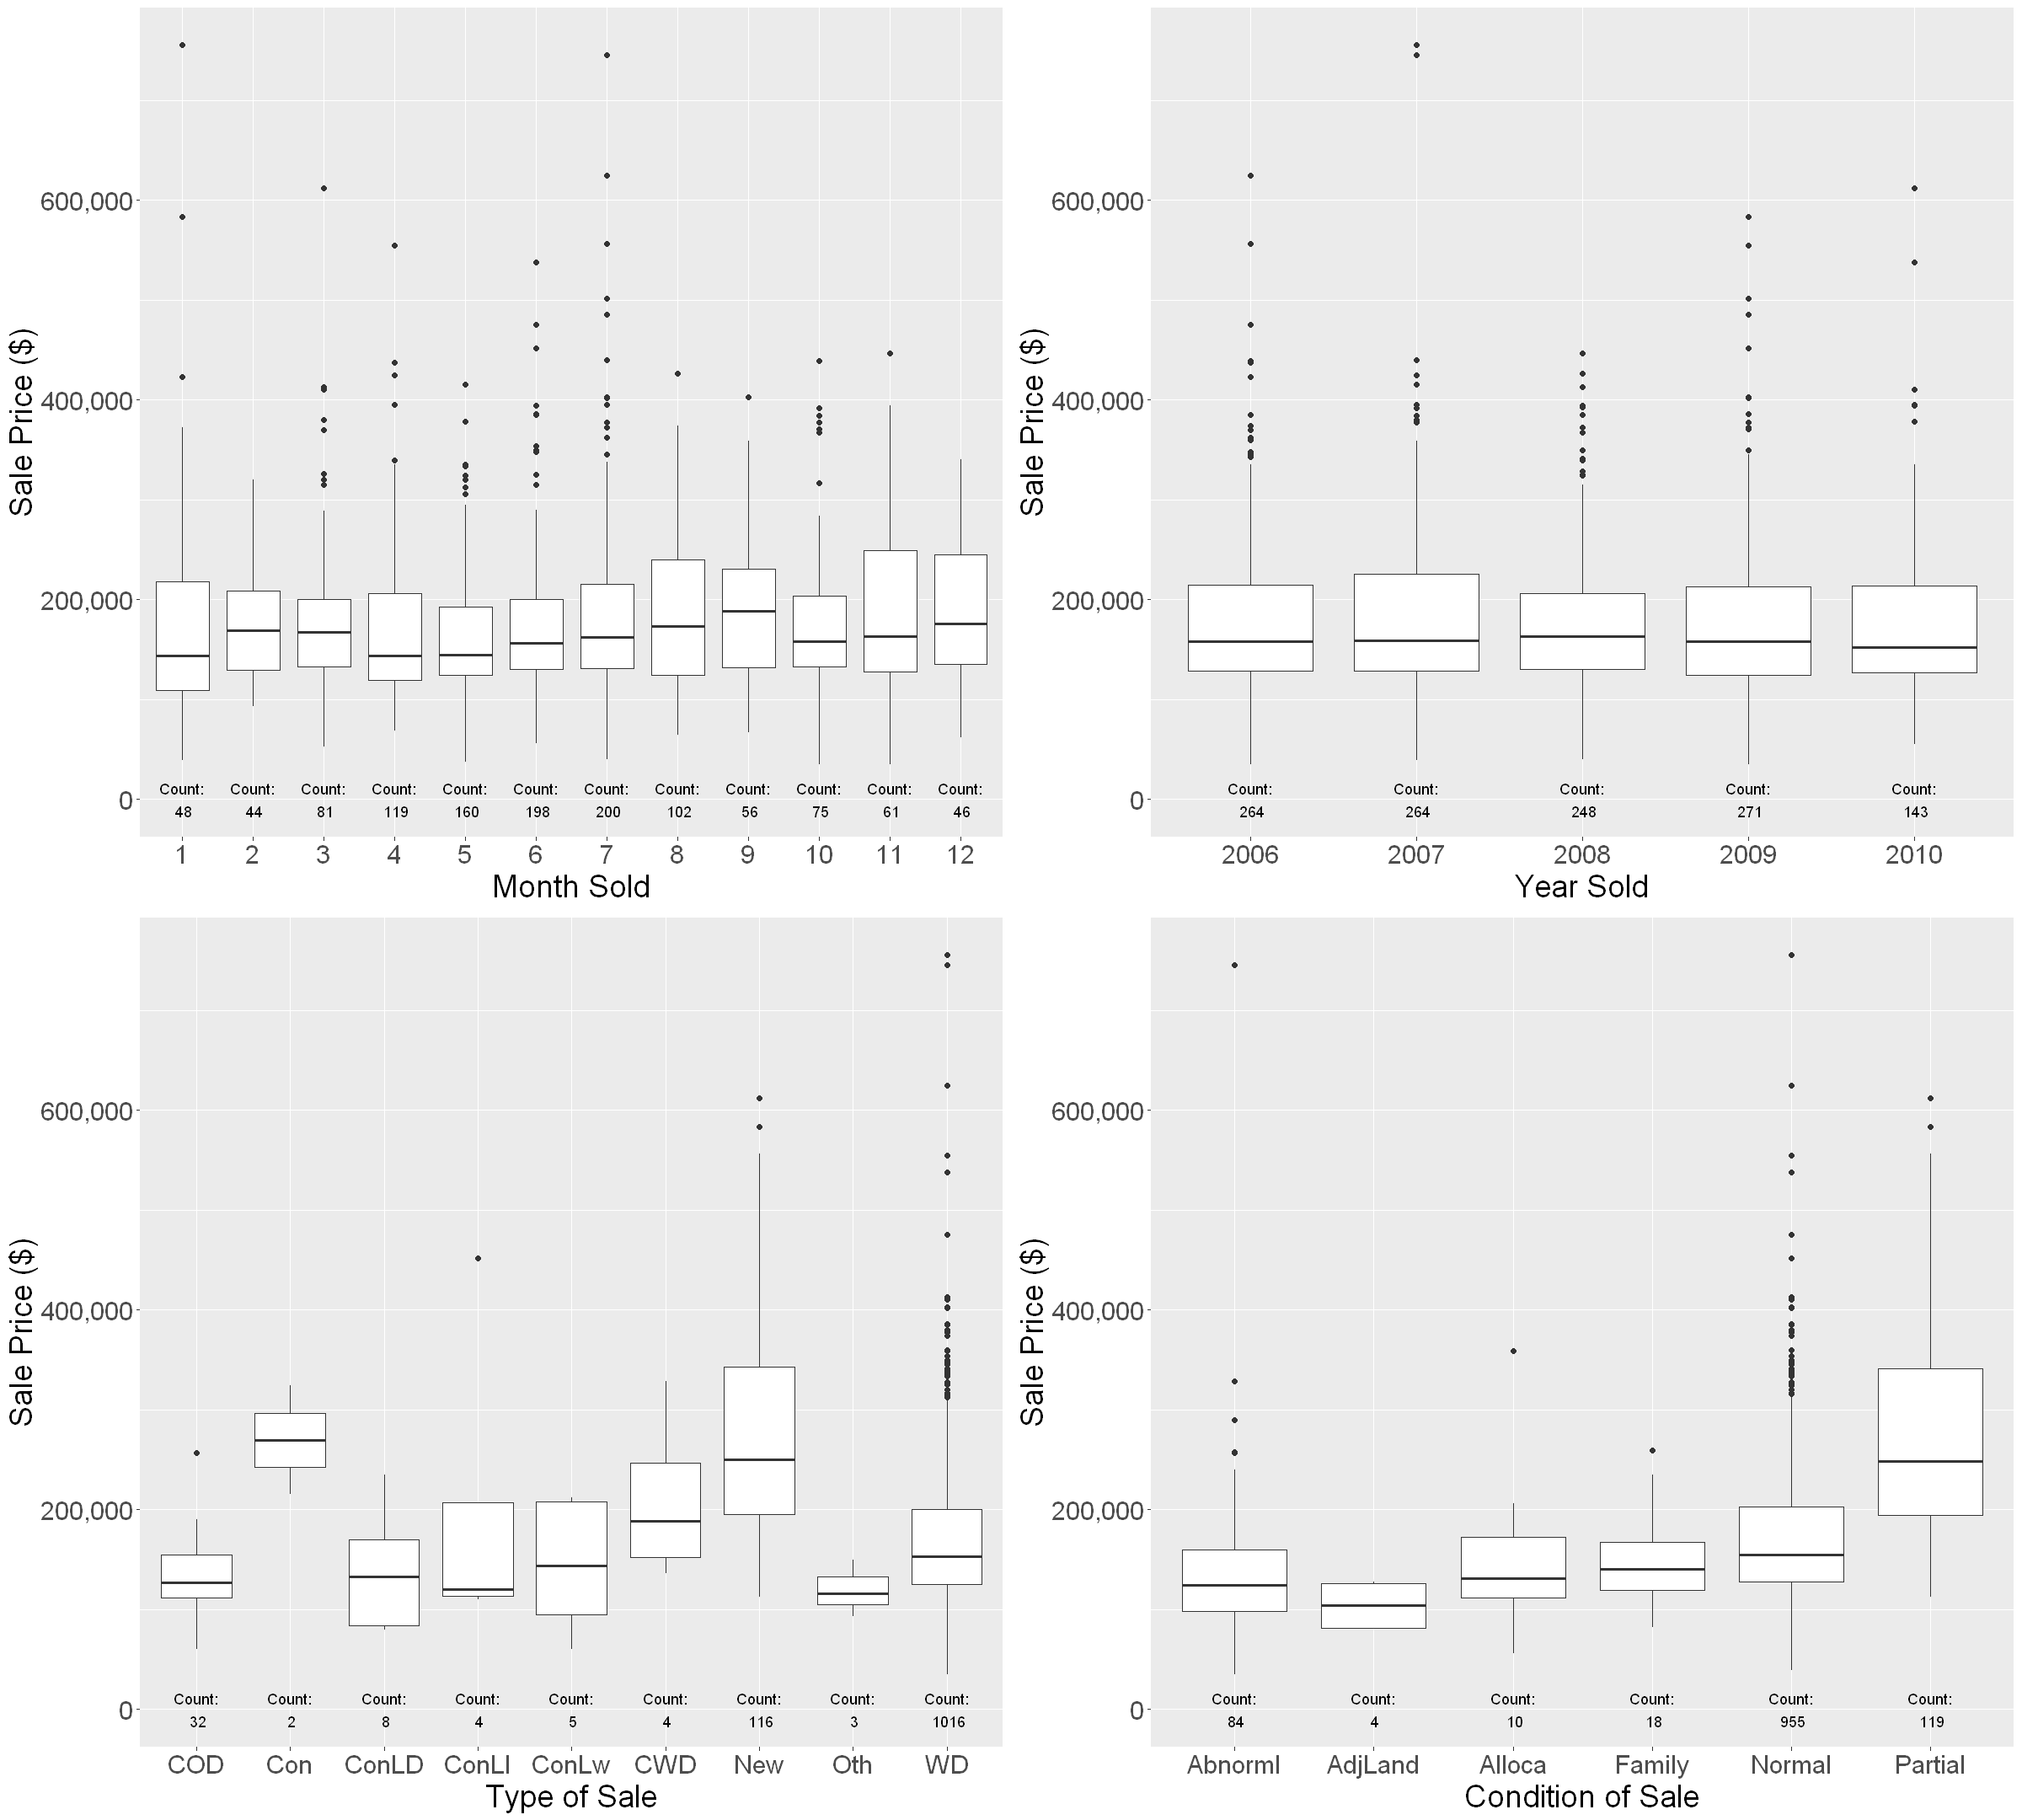

In [25]:
sale_time_cond <- c('MoSold', 'YrSold', 'SaleType', 'SaleCondition')
box_plots(train, sale_time_cond)

The sale price seems to vary slightly with the month of the sale, but there does not appear to be any obvious trends. The year of the sale doesn't seem to have any impact on sale price, and should be ignored. The type of the sale impacts sale price (unsurprisingly there is a noticeable difference between the prices for new construction versuses older homes). While it appears the condition of the sale impacts sale price, the partial category refers to the new homes there were assessed before completion, so this feature is probably confounded with the type of sale and only one should be included in the model.

This concludes the analysis of categorical variables and the exploratory data analysis. Now it is time to prepare features for use in models using the information gained from the EDA on which variables are relevant and the levels that should be considered.